# Automatic hyperparameter tuning for machine learning algorithms

Creating machine learning algorithm introduces us with concept of hyperparameters. Tuning hyperparameters is time consuming and can radically influence performance of the algorithm. Choosing right hyperparameter for your model is crucial task that can make model viable solution to a problem and enable it to generalize on different data. Same model with different set of data may require entirely different hyperparameters that will need to be tuned to a problem since we don’t know them beforehand. Given the above hyperparameter optimization is the problem of optimizing a loss function over a configuration space. 

## What are hyperparameters?

Hyperparameters are not model parameters and the can’t be learned from the data in contrast to model parameters. Model parameters are properties of model that will be adjusted during loss function optimization (weights or bias) while hyperparameters are properties of a model that determine who we conduct training process (learning rate, maximum depth of decision tree). 

## Methodology od hyperparameter tuning

There are several approaches for hyperparameter tuning. One of them is manual tuning which in effect takes away time from other steps of machine learning pipeline like feature engineering. This approach is very inefficient and oftentimes is substituted with grid and random search. Those two are automatic but require long run times since they evaluate areas of parameter grid that don’t give good results. Since manual search is taking up human time and grid and random search is time and computationally inefficient new methods have been proposed. 

#### Grid Search      

Grid search is most basic form of hyperparameter optimization, also called parameter sweep. It trains algorithm for all combinations of a manually specified hyperparameter space at the same time measuring performance with some metric (usually used with K-Fold cross validation). One of the drawbacks to performing grid search are fixed parameters in search space which combinations can omit minimum for specific performance metric.

#### Random Search

Random search randomly samples search space and evaluates sets from a specified probability space. Limits exhaustive enumeration of all combinations of random search. It can outperform grid search performance by assuming that in most data sets only a few of the hyperparameters matter.

#### Bayesian Optimisation

Bayesian approach finds extrema of objective function in informed way by keeping track of  previous results. Grid and random search perform every experiment in isolation and every next evaluation is not able to use information from previous runs to improve. Bayesian optimization thanks to record of previous evaluation is able to create a probabilistic model mapping hyperparameters to a probability of a score on the objective function. This model is called surrogate function or response surface. Picking next sample data for evaluation is done by acquisition function. Popular acquisition functions are:

Maximum Probability of Improvement 
- Expected Improvement
- Upper Confidence Bound
- Expected loss criterion


Bayesian optimization belongs to a class of sequential model-based optimization (SMBO) algorithms that allow for one to use the results of our previous iteration to improve our sampling method of the next experiment. Types of SMBO’s differ as well by the choice of surrogate model. Popular surrogate models are:

- Gaussian Processes 
- Random Forest Regressions 
- Tree Parzen Estimators 

### Lets create few evaluations of hyperparameter optimization modules and compare them

In [1]:
%%capture
############ IMPORTS ################

############ basic imports ##########
import numpy as np
from numpy.random import seed
import pandas as pd
from scipy.stats import randint
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import time

############ model imports ##########
from lightgbm.sklearn import LGBMClassifier

############ metrics ################
from sklearn.metrics import roc_auc_score

############ model select sklearn ##
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

############ basic training data ####
from sklearn.datasets import load_diabetes, load_breast_cancer

############ settings #########
random_state=42
n_iter=50
num_folds=2
verbose=0

############ silient mode ###########
import warnings                         
warnings.filterwarnings('ignore')



########### SEARCH MODULES ##########

########### sklearn search methods ##
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

########### hpsklearn search methods #
#from hpsklearn import HyperoptEstimator, xgboost_regression, xgboost_classification

########### hyperopt search methods###
from hyperopt import fmin, tpe, hp, anneal, Trials

########### skopt search methods #####
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize #gp minimize same as Bayes search
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
########### Handling errors while importing BayesSearch #####
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
        
########## GPyOpt search methods #####
import GPy
import GPyOpt

########## evolutionary search methods #
from evolutionary_search import EvolutionaryAlgorithmSearchCV

########## btb search methods #########
from btb import HyperParameter, ParamTypes
from btb.tuning import GP, Uniform

######### tpot imports ################
from tpot import TPOTRegressor, TPOTClassifier

######### auto_ml imports #############
from auto_ml import Predictor

In [2]:
######### implemantation of context manager to get time and collect data from different modules ################
class timer:
    '''Context manager object holding info about optimization methods run inside with block'''
    def __init__(self, name):
        self.name          = name
        self.cv_score      = None
        self.test_score    = None
        self.object        = None
        self.plot_data     = None
        self.best_params   = None
        
    # __enter__ and __exit__ are neccessary for context manager type. More info: https://docs.python.org/3/library/stdtypes.html#typecontextmanager    
    def __enter__(self):
        self._t0 = time.time()
        print(f'[{self.name}] -- Starting tuning')
        return self
    
    def __exit__(self, *params):
        self.time = time.time() - self._t0
        print(f'[{self.name}] -- Finished tuning')
        if isinstance(self.plot_data, pd.DataFrame):
            self.plot_data['score'] = self.plot_data['score'].astype('float')
            self.plot_data['learning_rate'] = self.plot_data['learning_rate'].astype('float')
            self.plot_data['max_depth'] = self.plot_data['max_depth'].astype('int')
            self.plot_data['n_estimators'] = self.plot_data['n_estimators'].astype('int')
        return None
    
    # printing instance of context manager will show info about evaluated optimization module
    def __str__(self):
        return f'##################### [{self.name}] ##################### \
        \n \
        \n   evaluated in:          {self.time:.2f} s\
        \n   best cros val auc was: {self.cv_score:.5f}\
        \n   best test auc was:     {self.test_score:.5f}\
        \n   best params:           {self.best_params} \n\n'
    
    def print_time(self):
        print(f'[{self.name}] evaluated in {self.time:.2f} s')
        
    def print_summary(self):
        print(self)
        self.plot()
        
    def print_score(self):
        print(f'[{self.name}] best test auc was {self.test_score:.5f}')
    
    def plot_params(self):
        if isinstance(self.plot_data, pd.DataFrame):
            print(f'\n-----------Ploting graphs for searched parameters for {self.name}-----------\n')
            plt.rcParams['font.size'] = 12
            
            fig, axs = plt.subplots(4, 1, figsize = (10, 12))
            i = 0
            for i, hyper in enumerate(['score', 'learning_rate', 'max_depth', 'n_estimators']):
                sns.lineplot(data=self.plot_data[hyper], ax = axs[i])
                axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over search'.format(hyper))

            plt.tight_layout()
            plt.show()
        else:
            print('No plot data')
            
    def plot_dist(self):
        if isinstance(self.plot_data, pd.DataFrame):
            print(f'\n-----------Ploting graphs of density of searched parameters for {self.name}-----------\n')
            plt.rcParams['font.size'] = 12
            
            fig, axs = plt.subplots(4, 1, figsize = (10, 12))
            i = 0
            for i, hyper in enumerate(['score', 'learning_rate', 'max_depth', 'n_estimators']):
                sns.kdeplot(self.plot_data[hyper], label = hyper, linewidth = 2, ax = axs[i], shade = True)
                axs[i].set(xlabel = 'Value', ylabel = '{}'.format(hyper), title = '{} density'.format(hyper))
                    
            plt.tight_layout()
            plt.show()
        else:
            print('No plot data')
            
    def plot_with_linreg(self):
        if isinstance(self.plot_data, pd.DataFrame):
            print(f'\n-----------Ploting graphs with linreg for {self.name}-----------\n')
            plt.rcParams['font.size'] = 12
            
            fig, axs = plt.subplots(1, 4, figsize = (24, 6))
            i = 0
            for i, hyper in enumerate(['score', 'learning_rate', 'max_depth', 'n_estimators']):
                sns.regplot(x='index', y=hyper, data = self.plot_data.reset_index(), ax = axs[i])
                #sns.lineplot(data=grid_search.plot_data[hyper], ax = axs[i])
                axs[i].set(
                    xlabel = 'Iteration', 
                    ylabel = '{}'.format(hyper), 
                    title = '{} over search with linreg'.format(hyper), 
                    ylim=(self.plot_data[hyper].min() * 0.9 ,self.plot_data[hyper].max() * 1.1)
                )
            plt.tight_layout()
            plt.show()
        else:
            print('No plot data')
        
    # show all kinds of plots for evaluated optimization module
    def plot_all(self):
        if isinstance(self.plot_data, pd.DataFrame):
            self.plot_params()
            self.plot_dist()
            self.plot_with_linreg()
        else:
            print('No plot data')
        

We now define function to load and process data so they will be ready to use with [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html). LightGBM is a gradient boosting framework that uses tree based learning algorithms. 
- Function `load_caravan()` will load and process data from [kaggle challange](https://www.kaggle.com/uciml/caravan-insurance-challenge)

In [3]:
def load_caravan():    
    data = pd.read_csv('data/caravan-insurance-challenge.csv')
    train = data[data['ORIGIN'] == 'train']
    test = data[data['ORIGIN'] == 'test']


    train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
    y_test = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))


    train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
    test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

    X_train = np.array(train)
    X_test = np.array(test)
    y_train = train_labels[:]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = load_caravan()

kf = KFold(n_splits=num_folds, random_state=random_state)

We will append all functions that wrap our optimization methods so we can iterate over them and train as one batch from `eval_array`.

In [4]:
eval_array = []

## Basic LightGBM model
This model is trained as reference point (baseline) without specifying any parameters. It is done in two steps. First we wrap context manager object in function and than call function. Context manager object purpose is to collect time and data about trained model, training steps and scores.

In [5]:
def evaluate_basic_lgbm(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Basic LGBM') as t:
        
        # instantiate LGBM
        model = LGBMClassifier(random_state=random_state)
        
        # assign test score to context object
        t.cv_score = cross_val_score(
            model, 
            train_data, 
            train_targets, 
            cv=kf, 
            scoring="roc_auc", 
            n_jobs=1, 
            verbose=verbose
        ).mean()
        
        # assign best model to context object
        t.object = model.fit(train_data, train_targets)
        # assign test score
        t.test_score = roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.best_params = t.object.get_params()

    return t

This model will not be appended to `eval_array`. The way to invoke and print some info about our model (later it will be optimization function that we will append to `eval_array`) is show below. First we run the function that is wraping our context manager. Function will return context manager object with all the info that we will use to evalute optimization modules. In this case we will only have info about `cross_val_score`, `roc_auc_score`, `get_params()` and time. Calling plot method on object will return info about lack of data to plot. 

In [6]:
basic_lgbm = evaluate_basic_lgbm()
print(basic_lgbm)
basic_lgbm.plot_all()

[Basic LGBM] -- Starting tuning
[Basic LGBM] -- Finished tuning
##################### [Basic LGBM] #####################         
         
   evaluated in:          0.77 s        
   best cros val auc was: 0.72201        
   best test auc was:     0.71431        
   best params:           {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 1} 


No plot data


## Grid Search
Evaluating standard sklearn [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). From documentation: "Exhaustive search over specified parameter values for an estimator."

In [7]:
def evaluate_gridsearch(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('GridSearch') as t:
        # instantiate LGBMClassifier
        model = LGBMClassifier(random_state=random_state, n_jobs=-1)
        # define search space
        param_grid={'learning_rate': np.logspace(-4, -1, 3),
                    'max_depth':  np.linspace(2,20, 5,dtype = int),
                    'n_estimators': np.linspace(50, 2000, 5, dtype = int),
                    'random_state': [random_state]}
        # perform GridSearch
        gs=GridSearchCV(
            model, 
            param_grid, 
            scoring='roc_auc', 
            fit_params=None, 
            n_jobs=-1, 
            cv=kf, 
            verbose=verbose
        )
        
        gs.fit(train_data, train_targets)
        # 
        t.object = gs
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = t.object.best_score_
        t.best_params = t.object.best_params_
        
        # get pandas frame of parameter data across iterations of search space
        t.plot_data=pd.DataFrame(np.transpose([t.object.cv_results_['mean_test_score'],
                                         t.object.cv_results_['param_learning_rate'].data,
                                         t.object.cv_results_['param_max_depth'].data,
                                         t.object.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])     
    return t

Append `evaluate_gridsearch` to array

In [8]:
eval_array.append(evaluate_gridsearch)

## Random Search
Evaluating sklearn [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

In [9]:
def evaluate_randomsearch(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('RandomSearch') as t:
        
        model = LGBMClassifier(random_state=random_state, n_jobs=-1)

        param_grid_rand={'learning_rate': np.logspace(-4, -1, 100),
                         'max_depth':  randint(2,20),
                         'n_estimators': randint(50,2000),
                         'random_state': [random_state]}

        rs=RandomizedSearchCV(
            model, 
            param_grid_rand, 
            n_iter = int(n_iter*1.4), #trying to even out time of search 
            scoring='roc_auc', 
            fit_params=None, 
            n_jobs=-1, 
            cv=kf, 
            verbose=verbose, 
            random_state=random_state
        )

        rs.fit(train_data, train_targets)
        t.object = rs
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = t.object.best_score_
        t.best_params = t.object.best_params_
        
        t.plot_data=pd.DataFrame(np.transpose([t.object.cv_results_['mean_test_score'],
                                         t.object.cv_results_['param_learning_rate'].data,
                                         t.object.cv_results_['param_max_depth'].data,
                                         t.object.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
    return t

In [10]:
eval_array.append(evaluate_randomsearch)

## Hyperopt
[Hyperopt](https://hyperopt.github.io/hyperopt-sklearn/) is one of many automated search modules for hyperparameter tuning. Hyperopt is using Bayesian optimization. Search algorithms available in hyperopt include Random Search, Tree of Parzen Estimators (TPE), Annealing, Tree, Gaussian Process Tree. Lets define objective function that we will try to minimize with hyperopt.

In [11]:
# hyperopt objective function
def objective_hyperopt(params, random_state=random_state, cv=kf, X=X_train, y=y_train):
    
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    
    model = LGBMClassifier(random_state=random_state, **params, n_jobs=-1)
    
    score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    return score

#### Tree of Parzen Estimators

In [12]:
def evaluate_hyperopt_tpe(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf, objective=objective_hyperopt):
    with timer('Hyperopt TPE') as t:

        # defining search space
        space={'n_estimators': hp.quniform('n_estimators', 50, 2000, 1),
               'max_depth' : hp.quniform('max_depth', 2, 20, 1),
               'learning_rate': hp.loguniform('learning_rate', -4, -1)
              }

        # trials will log information about every evaluation
        trials = Trials()

        best=fmin(fn=objective, # function to optimize
                  space=space, 
                  algo=tpe.suggest, # optimization algorithm
                  max_evals=n_iter, 
                  trials=trials,
                  rstate=np.random.RandomState(random_state)
                 )


        model = LGBMClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),learning_rate=best['learning_rate'])
        model.fit(train_data, train_targets)
        t.object = model
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = 1 - objective(best)
        t.best_params = best
        
        tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

        t.plot_data=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        t.plot_data['score'] = 1 - t.plot_data['score']
        
    return t

In [13]:
eval_array.append(evaluate_hyperopt_tpe)

#### Annealing

In [14]:
def evaluate_hyperopt_anneal(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf, objective=objective_hyperopt):
    with timer('Hyperopt Anneal') as t:
        
        space={'n_estimators': hp.quniform('n_estimators', 50, 2000, 1),
               'max_depth' : hp.quniform('max_depth', 2, 20, 1),
               'learning_rate': hp.loguniform('learning_rate', -4, -1)
              }

       
        trials = Trials()

        best=fmin(fn=objective_hyperopt, 
                  space=space, 
                  algo=anneal.suggest, 
                  max_evals=int(n_iter*1.2), 
                  trials=trials, 
                  rstate=np.random.RandomState(random_state) 
                 )

        # computing the score on the test set
        model = LGBMClassifier(random_state=random_state, n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),learning_rate=best['learning_rate'], n_jobs=-1, verbose=1)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = 1 - objective(best)
        t.best_params = best
        
        tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['learning_rate'][0],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

        t.plot_data=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        t.plot_data['score'] = 1 - t.plot_data['score']
    return t

In [15]:
eval_array.append(evaluate_hyperopt_anneal)

## Scikit-Optimize - skopt
Scikit-Optimize, or [skopt](https://scikit-optimize.github.io/), is a simple module to minimize expensive black-box functions like hyperparameter optimization. It implements several methods for sequential model-based optimization. BayesSearchCV implements a `fit`, `predict`, `predict_proba` and a `score` methods. We can use it as regullar sklearn search classes.

In [16]:
############## skopt with sklearn api
def evaluate_skopt_bayes(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf, optimizer={'base_estimator':'RF', 'acq_func':'PI', 'acq_optimizer':'auto'}):
    with timer('Scikit-Optimize API Bayes') as t:
        
        model = LGBMClassifier(random_state=random_state, n_jobs=8)
        
        param_grid_bayes={'learning_rate': Real(1e-5, 1e-1, prior='log-uniform'),
                         'max_depth':  Integer(2,20),
                         'n_estimators': Integer(50,2000)
                         }

        bs=BayesSearchCV(model, param_grid_bayes, n_iter = int(n_iter*1.3), scoring='roc_auc', fit_params=None, 
                        n_jobs=8, cv=kf, random_state=random_state, optimizer_kwargs=optimizer)

        bs.fit(train_data, train_targets)

        t.object = bs
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = t.object.best_score_
        t.best_params = t.object.best_params_
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(t.object.cv_results_['mean_test_score']),
                                         t.object.cv_results_['param_learning_rate'],
                                         t.object.cv_results_['param_max_depth'],
                                         t.object.cv_results_['param_n_estimators']]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        
    return t

In [17]:
eval_array.append(evaluate_skopt_bayes)

#### Scikit-Optimize with objective function
You can use skopt to minimize objective function over search space as well. Without sklearn API.

In [18]:
space  = [Integer(2, 20, name='max_depth'),
          Real(10**-4, 10**-1, "log-uniform", name='learning_rate'),
          Integer(50, 2000, name='n_estimators')]



@use_named_args(space)
def objective_skopt(random_state=random_state, cv=kf, X=X_train, y=y_train,**space):    

    model = LGBMClassifier(random_state=random_state, n_jobs=-1)
    model.set_params(**space)
    
    score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    return 1-score

In [19]:
def evaluate_skopt_bayes_dummy(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Scikit-Optimize dummy minimize') as t:

        res_gp = dummy_minimize(objective_skopt, space, n_calls=int(n_iter*0.9), random_state=random_state)

        # computing the score on the test set
        model = LGBMClassifier(random_state=random_state, n_estimators=int(res_gp.x[2]),
                              max_depth=int(res_gp.x[0]),learning_rate=res_gp.x[1], n_jobs=-1, verbose=verbose)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = 1-res_gp.fun
        t.best_params = {'learning_rate': res_gp.x[1], 'max_depth': int(res_gp.x[0]), 'n_estimators': int(res_gp.x[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(res_gp.func_vals),
            np.array(res_gp.x_iters)[:,1], #learning rate
            np.array(res_gp.x_iters)[:,2], #n estimators
            np.array(res_gp.x_iters)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        t.plot_data['score'] = 1 - t.plot_data['score']
    return t

In [20]:
eval_array.append(evaluate_skopt_bayes_dummy)

In [21]:
def evaluate_skopt_bayes_forest(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Scikit-Optimize forest minimize') as t:

        res_forest = forest_minimize(objective_skopt, space, n_calls=int(n_iter*1.3), random_state=random_state)

        model = LGBMClassifier(random_state=random_state, n_estimators=int(res_forest.x[2]),
                      max_depth=int(res_forest.x[0]),learning_rate=res_forest.x[1], n_jobs=-1, verbose=verbose)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = 1-res_forest.fun
        t.best_params = {'learning_rate': res_forest.x[1], 'max_depth': int(res_forest.x[0]), 'n_estimators': int(res_forest.x[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(res_forest.func_vals),
            np.array(res_forest.x_iters)[:,1], #learning rate
            np.array(res_forest.x_iters)[:,2], #n estimators
            np.array(res_forest.x_iters)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        t.plot_data['score'] = 1 - t.plot_data['score']
    return t

In [22]:
eval_array.append(evaluate_skopt_bayes_forest)

In [23]:
def evaluate_skopt_bayes_gbrt(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Scikit-Optimize gbrt minimize') as t:

        res_gbrt = gbrt_minimize(objective_skopt, space, n_calls=int(n_iter*1.3), random_state=random_state)

        model = LGBMClassifier(random_state=random_state, n_estimators=int(res_gbrt.x[2]),
                      max_depth=int(res_gbrt.x[0]),learning_rate=res_gbrt.x[1], n_jobs=-1, verbose=verbose)
        model.fit(train_data,train_targets)
        t.object = model
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = 1-res_gbrt.fun
        t.best_params = {'learning_rate': res_gbrt.x[1], 'max_depth': int(res_gbrt.x[0]), 'n_estimators': int(res_gbrt.x[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(res_gbrt.func_vals),
            np.array(res_gbrt.x_iters)[:,1], #learning rate
            np.array(res_gbrt.x_iters)[:,2], #n estimators
            np.array(res_gbrt.x_iters)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        t.plot_data['score'] = 1 - t.plot_data['score']
    return t

In [24]:
eval_array.append(evaluate_skopt_bayes_gbrt)

## GPyOpt
[GPyOpt](https://github.com/SheffieldML/GPyOpt) is yet another module using bayesian methods to search parameter space to optimize objective function. 

In [25]:
seed(random_state)

domain =[{'name': 'max_depth',   'type': 'discrete', 'domain': np.linspace(2,20, dtype=int)},
       {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.1)},
       {'name': 'n_estimators',  'type': 'discrete', 'domain': np.linspace(50,2000, dtype=int)}
      ]


def bayes_lgbm_gpy(x, mdl=None, cv=None):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0], 1))
    for i, params in enumerate(x):
        dict_params = dict(zip([el['name'] for el in domain], params))
        dict_params['max_depth'] = int(dict_params['max_depth'])
        dict_params['n_estimators'] = int(dict_params['n_estimators'])
        
        mdl.set_params(**dict_params)
        fs[i] = 1-cross_val_score(mdl, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    return fs


def evaluate_gpyopt(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('GPyOpt') as t:
        opt = GPyOpt.methods.BayesianOptimization(f = partial(bayes_lgbm_gpy, mdl=LGBMClassifier(random_state=random_state, n_jobs=-1), cv=kf),       
                                                  domain = domain,         # box-constrains of the problem
                                                  model_type= 'GP',
                                                  acquisition_type='MPI',
                                                  num_cores=8,
                                                  #acquisition_weight = 0.01
                                                 )  
        # https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html?highlight=acquisition_type
        opt.run_optimization(max_iter=int(n_iter*1.1))
        
        model = LGBMClassifier(random_state=random_state, n_estimators=int(opt.x_opt[2]),
                      max_depth=int(opt.x_opt[0]), learning_rate=opt.x_opt[1], n_jobs=-1, verbose=1)
        t.object = model
        t.object.fit(train_data,train_targets)
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score = 1-opt.fx_opt
        t.best_params = {'learning_rate': opt.x_opt[1], 'max_depth': int(opt.x_opt[0]), 'n_estimators': int(opt.x_opt[2])}
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(opt.Y)[:,0],
            np.array(opt.X)[:,1], #learning rate
            np.array(opt.X)[:,2], #n estimators
            np.array(opt.X)[:,0]]), #max depth
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
        t.plot_data['score'] = 1 - t.plot_data['score']
    return t

In [26]:
eval_array.append(evaluate_gpyopt)

## sklearn-deap
[sklearn-deap](https://github.com/rsteca/sklearn-deap) is different than other optimization modules. In its basis it uses evolutionary algorithms to optimize scikit models. It should allow you to exponentially reduce the time required to find the best parameters. Instead of trying out every possible combination of parameters, "evolve" only the combinations that give the best results.

In [27]:
seed(random_state)

param_grid={'learning_rate': np.logspace(-4, -1, 1000),
            'max_depth':  np.linspace(2, 20, 20-1, dtype = int),
            'n_estimators': np.linspace(50 ,2000, 2000-50, dtype = int),
            'random_state': [random_state]}

# print("Size: ", len(param_grid["learning_rate"])*len(param_grid["max_depth"])*len(param_grid["n_estimators"]))
def evaluate_evolutionary(train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('Evolutionary Algorithm Search') as t:
        model = LGBMClassifier(random_state=random_state, n_jobs=-1)
        evol=EvolutionaryAlgorithmSearchCV(model, 
                                           param_grid, 
                                           scoring='roc_auc', 
                                           fit_params=None, 
                                           n_jobs=1, 
                                           cv=kf, 
                                           verbose=verbose, 
                                           population_size=16,
                                           gene_mutation_prob=0.60,
                                           gene_crossover_prob=0.5,
                                           tournament_size=3,
                                           generations_number=10)


        evol.fit(train_data, train_targets)
        t.object = evol
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])
        t.cv_score=t.object.best_score_
        t.best_params=t.object.best_params_
        
        t.plot_data=pd.DataFrame(np.transpose([np.array(evol.cv_results_['mean_test_score']),
                                         [item['learning_rate'] for item in evol.cv_results_['params']],
                                         [item['max_depth'] for item in evol.cv_results_['params']],
                                         [item['n_estimators'] for item in evol.cv_results_['params']]]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])    
    return t

In [28]:
eval_array.append(evaluate_evolutionary)

## Bayesian Tuning and Bandits
[BTB](https://github.com/HDI-Project/BTB) "is a simple, extensible backend for developing auto-tuning systems such as AutoML systems" as the name implays it uses Bayesian methods.

In [29]:
seed(random_state)
tunables = [
    ('n_estimators', HyperParameter(ParamTypes.INT, [50, 2000])),
    ('max_depth', HyperParameter(ParamTypes.INT, [2, 20])),
    ('learning_rate', HyperParameter(ParamTypes.FLOAT_EXP, [0.0001, 0.1]))
]

def evaluate_btb(tuner=GP(tunables), train_data=X_train, train_targets=y_train, test_data=X_test, test_targets=y_test, kf=kf):
    with timer('BTB') as t:

        for i in range(n_iter*2):
            params = tuner.propose()

            model = LGBMClassifier(random_state=random_state, 
                                  n_jobs=-1,
                                  n_estimators=params['n_estimators'],
                                  max_depth=params['max_depth'],
                                  learning_rate=params['learning_rate']
                                 )

            score = cross_val_score(model, train_data, train_targets, cv=kf, scoring="roc_auc", n_jobs=-1).mean()
            tuner.add(params, score)
            
            
        model = LGBMClassifier(random_state=random_state, n_estimators=tuner._best_hyperparams['n_estimators'],
                      max_depth=tuner._best_hyperparams['max_depth'],learning_rate=tuner._best_hyperparams['learning_rate'], n_jobs=-1, verbose=1)
        model.fit(train_data,train_targets)
        t.object = model
        t.cv_score = tuner._best_score
        t.best_params = tuner._best_hyperparams
        t.test_score=roc_auc_score(test_targets, t.object.predict_proba(test_data)[:, 1])    
        t.plot_data=pd.DataFrame(np.transpose([np.array(tuner.y),
                                         10**tuner.X[:,2],
                                         tuner.X[:,1],
                                         tuner.X[:,0]]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
    return t

In [30]:
eval_array.append(evaluate_btb)

Lets evaluate all functions that we appended to `eval_array`

In [ ]:
%%time
evaluated_array = []
for i, f in enumerate(eval_array):
    i = i+1
    string = '#'*i
    print("Evaluating function {} of {}. Progress -> [{}] - {}%".format(i, 
                                                                        len(eval_array), 
                                                                        string.ljust(len(eval_array)), 
                                                                        int(100*i/(len(eval_array)))
                                                                        ))
    func = f()
    print(func)
    evaluated_array.append(func)

Evaluating function 1 of 11. Progress -> [#          ] - 9%
[GridSearch] -- Starting tuning
[GridSearch] -- Finished tuning
##################### [GridSearch] #####################         
         
   evaluated in:          113.55 s        
   best cros val auc was: 0.76316        
   best test auc was:     0.72839        
   best params:           {'learning_rate': 0.0031622776601683794, 'max_depth': 2, 'n_estimators': 2000, 'random_state': 42} 


Evaluating function 2 of 11. Progress -> [##         ] - 18%
[RandomSearch] -- Starting tuning
[RandomSearch] -- Finished tuning
##################### [RandomSearch] #####################         
         
   evaluated in:          125.33 s        
   best cros val auc was: 0.76137        
   best test auc was:     0.72481        
   best params:           {'learning_rate': 0.04328761281083057, 'max_depth': 2, 'n_estimators': 697, 'random_state': 42} 


Evaluating function 3 of 11. Progress -> [###        ] - 27%
[Hyperopt TPE] -- Startin

The higher the score the better the result of model predictions. Lets plot how did the score of a model change with number of iterations.

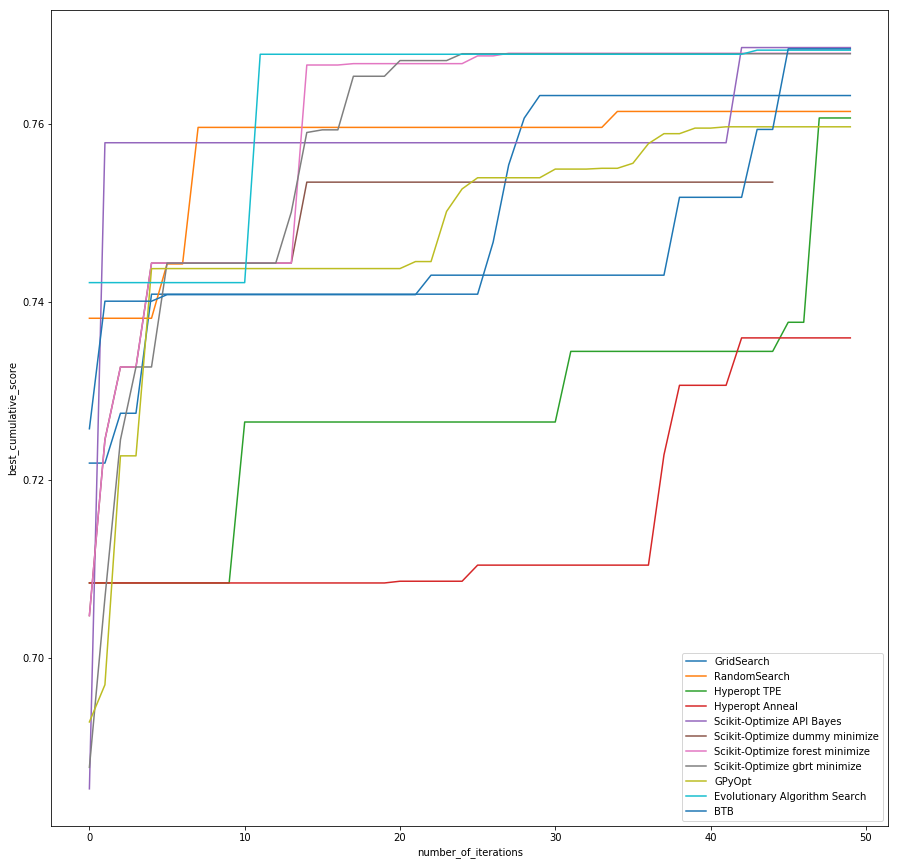

In [33]:
scores_df=pd.DataFrame(index=range(n_iter))
for elm in evaluated_array:
    scores_df[elm.name] = elm.plot_data['score'].cummax()

ax = scores_df.plot(figsize=(15, 15))

ax.set_xlabel("number_of_iterations")
ax.set_ylabel("best_cumulative_score")
plt.show()

In this plot you can see how cross validation roc_auc score changes with each iteration. GridSearch and RandomSearch are performing relatively well. Scikit-Optimize with API for sklearn that performed Bayesian optimization found really good score in only few iterations. Except of Hyperopt all search algoritms seem to be performing more or less equally (that might be a foult of seed not hyperopt).  

In [33]:
print('Test MSE scored:')
for elm in evaluated_array:
    print("{} - {:.5f}".format(elm.name, elm.test_score))

Test MSE scored:
GridSearch - 0.72839
RandomSearch - 0.72481
Hyperopt TPE - 0.72657
Hyperopt Anneal - 0.72468
Scikit-Optimize API Bayes - 0.73091
Scikit-Optimize dummy minimize - 0.72618
Scikit-Optimize forest minimize - 0.73092
Scikit-Optimize gbrt minimize - 0.73104
GPyOpt - 0.73071
Evolutionary Algorithm Search - 0.73262
BTB - 0.72980


Lets see which optimization module performed best on test data.

In [49]:
stat_frame = pd.DataFrame(columns=['module', 'time', 'mean_score', 'max_score', 'min_score', 'std_score', 'best_test_score'])
stat_frame = stat_frame.append(
    pd.DataFrame(
        [[elm.name, 
          elm.time, 
          elm.plot_data['score'].mean(), 
          elm.plot_data['score'].max(), 
          elm.plot_data['score'].min(), 
          elm.plot_data['score'].std(),
          elm.test_score] for elm in evaluated_array], 
        columns=['module', 'time', 'mean_score', 'max_score', 'min_score', 'std_score', 'best_test_score']
    )
)


Full results frame:

In [52]:
stat_frame.sort_values('best_test_score', ascending=False)

,module,time,mean_score,max_score,min_score,std_score,best_test_score
8,GPyOpt,126.398460,0.724345,0.759651,0.687008,0.024938,0.732791
7,Scikit-Optimize gbrt minimize,119.070271,0.744376,0.767985,0.681166,0.029518,0.731037
9,Evolutionary Algorithm Search,146.776649,0.761021,0.768298,0.716995,0.012505,0.730996
6,Scikit-Optimize forest minimize,103.443985,0.743273,0.767902,0.685795,0.023299,0.730918
4,Scikit-Optimize API Bayes,127.444987,0.738316,0.768546,0.676084,0.025130,0.730913
10,BTB,38.922256,0.718122,0.768406,0.682311,0.021268,0.729799
0,GridSearch,104.885899,0.708901,0.763161,0.660464,0.026685,0.728392
2,Hyperopt TPE,93.119660,0.703758,0.760643,0.678139,0.018647,0.726572
5,Scikit-Optimize dummy minimize,123.534333,0.713060,0.753440,0.676324,0.020347,0.726178
1,RandomSearch,102.349862,0.716299,0.761375,0.675341,0.023313,0.724807


In [50]:
stat_frame.sort_values('best_test_score', ascending=False)[['module', 'best_test_score']]

,module,best_test_score
8,GPyOpt,0.732791
7,Scikit-Optimize gbrt minimize,0.731037
9,Evolutionary Algorithm Search,0.730996
6,Scikit-Optimize forest minimize,0.730918
4,Scikit-Optimize API Bayes,0.730913
10,BTB,0.729799
0,GridSearch,0.728392
2,Hyperopt TPE,0.726572
5,Scikit-Optimize dummy minimize,0.726178
1,RandomSearch,0.724807


GpyOpt found best parameters that performed well on test data. All Bayesian algorithms and evolutionary one did score above 73% ROC AUC. RandomSearch and GridSearch are on the lower end. With this two you can get realy lucky and score great on first atemmpt. This is not very predictible behavior and as metiod before you have to get lucky.

Lets see which algoritms are most consistent.

In [47]:
stat_frame.sort_values('mean_score', ascending=False)[['module', 'mean_score']]

,module,mean_score
9,Evolutionary Algorithm Search,0.761021
7,Scikit-Optimize gbrt minimize,0.744376
6,Scikit-Optimize forest minimize,0.743273
4,Scikit-Optimize API Bayes,0.738316
8,GPyOpt,0.724345
10,BTB,0.718122
1,RandomSearch,0.716299
5,Scikit-Optimize dummy minimize,0.713060
3,Hyperopt Anneal,0.712044
0,GridSearch,0.708901


Again Scikit-Optimize with evolutionary algorithm is in the first few places as indicated by mean score in all iteration.

In [48]:
stat_frame.sort_values('std_score', ascending=True)[['module', 'std_score']]

,module,std_score
9,Evolutionary Algorithm Search,0.012505
3,Hyperopt Anneal,0.014893
2,Hyperopt TPE,0.018647
5,Scikit-Optimize dummy minimize,0.020347
10,BTB,0.021268
6,Scikit-Optimize forest minimize,0.023299
1,RandomSearch,0.023313
8,GPyOpt,0.024938
4,Scikit-Optimize API Bayes,0.025130
0,GridSearch,0.026685


Standard deviation of scores shows how precise Evolutionary Algorith Search is.

Next plots show values of hyperparameters that were proposed by search algorithm with each iteration. Plot in top shows how did score change with every change in hyperparameters.

Lets define helper function for ploting with names and params

In [58]:
def plot_params_of_algo(i):
    print(evaluated_array[i])
    evaluated_array[i].plot_params()

##################### [GridSearch] #####################         
         
   evaluated in:          104.89 s        
   best cros val auc was: 0.76316        
   best test auc was:     0.72839        
   best params:           {'learning_rate': 0.0031622776601683794, 'max_depth': 2, 'n_estimators': 2000, 'random_state': 42} 



-----------Ploting graphs for searched parameters for GridSearch-----------



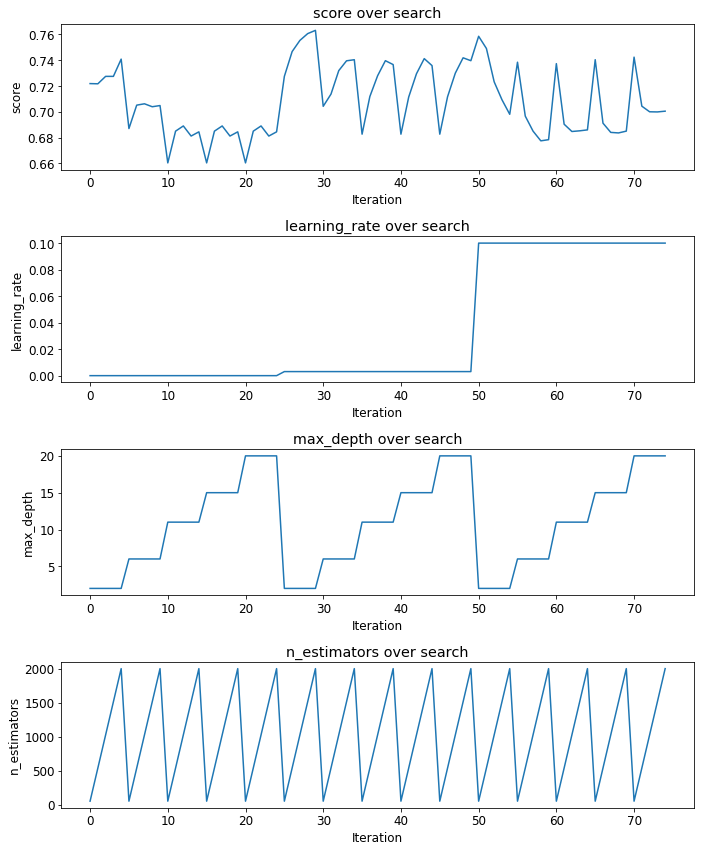

In [59]:
plot_params_of_algo(0)

GridSearch just sweaps all combinations of given params. You can clearly see how score changes with learning rate and n_estimators.

##################### [RandomSearch] #####################         
         
   evaluated in:          102.35 s        
   best cros val auc was: 0.76137        
   best test auc was:     0.72481        
   best params:           {'learning_rate': 0.04328761281083057, 'max_depth': 2, 'n_estimators': 697, 'random_state': 42} 



-----------Ploting graphs for searched parameters for RandomSearch-----------



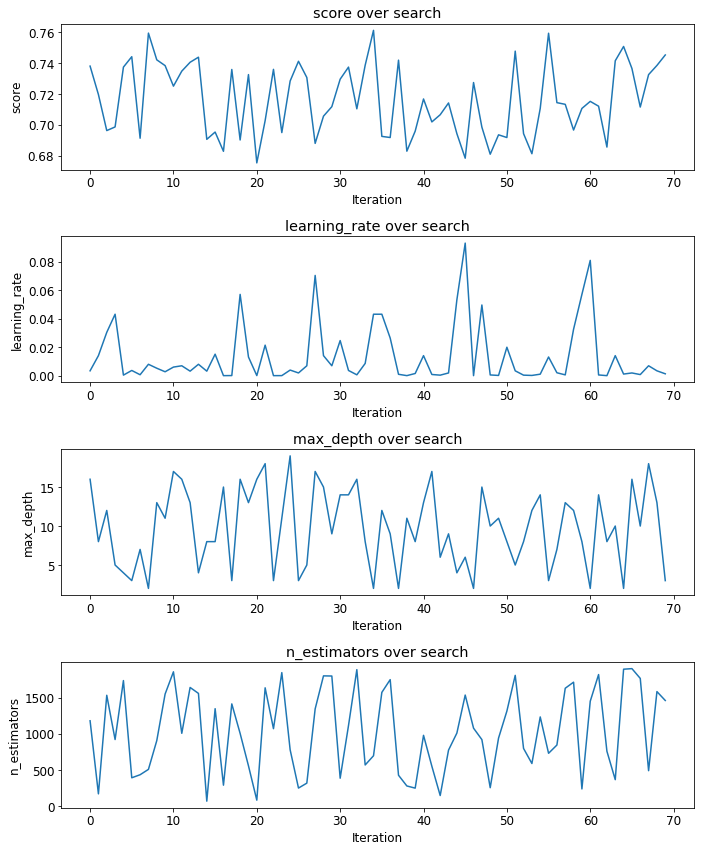

In [60]:
plot_params_of_algo(1)

##################### [Hyperopt TPE] #####################         
         
   evaluated in:          93.12 s        
   best cros val auc was: 0.76064        
   best test auc was:     0.72657        
   best params:           {'learning_rate': 0.021503410723880467, 'max_depth': 2.0, 'n_estimators': 1501.0} 



-----------Ploting graphs for searched parameters for Hyperopt TPE-----------



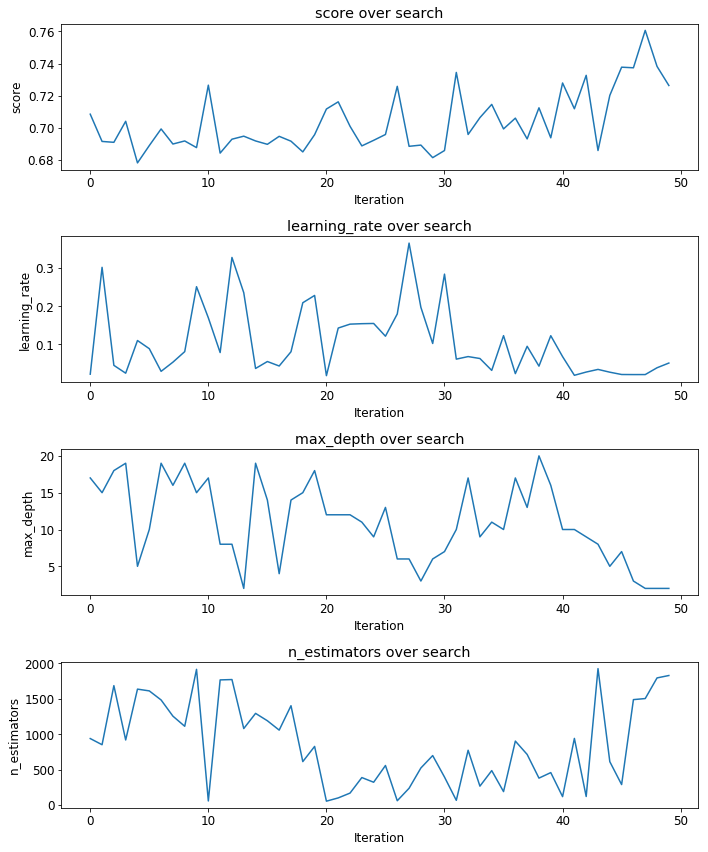

In [61]:
plot_params_of_algo(2)

You can see here that Hyperopt with TPE couldn't find good combination of learning rate and n_estimators. When found it tried to stick with it and the score started to increase in the end of search.

##################### [Hyperopt Anneal] #####################         
         
   evaluated in:          107.61 s        
   best cros val auc was: 0.74110        
   best test auc was:     0.72468        
   best params:           {'learning_rate': 0.02796190805453965, 'max_depth': 16.0, 'n_estimators': 229.0} 



-----------Ploting graphs for searched parameters for Hyperopt Anneal-----------



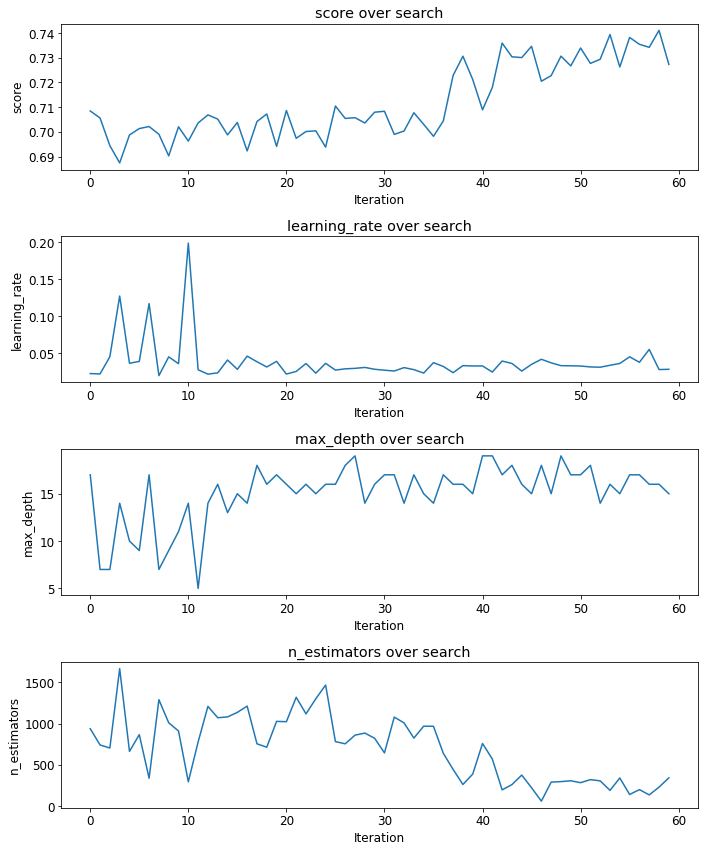

In [62]:
plot_params_of_algo(3)

Annealing algoritm for Hyperopt had a litle more consistent aproach. It started to rise from beggining and was still increasing when the search ended. It might have been better if given more time or smaller search space.

##################### [Scikit-Optimize API Bayes] #####################         
         
   evaluated in:          127.44 s        
   best cros val auc was: 0.76855        
   best test auc was:     0.73091        
   best params:           {'learning_rate': 0.021801357838009346, 'max_depth': 2, 'n_estimators': 691} 



-----------Ploting graphs for searched parameters for Scikit-Optimize API Bayes-----------



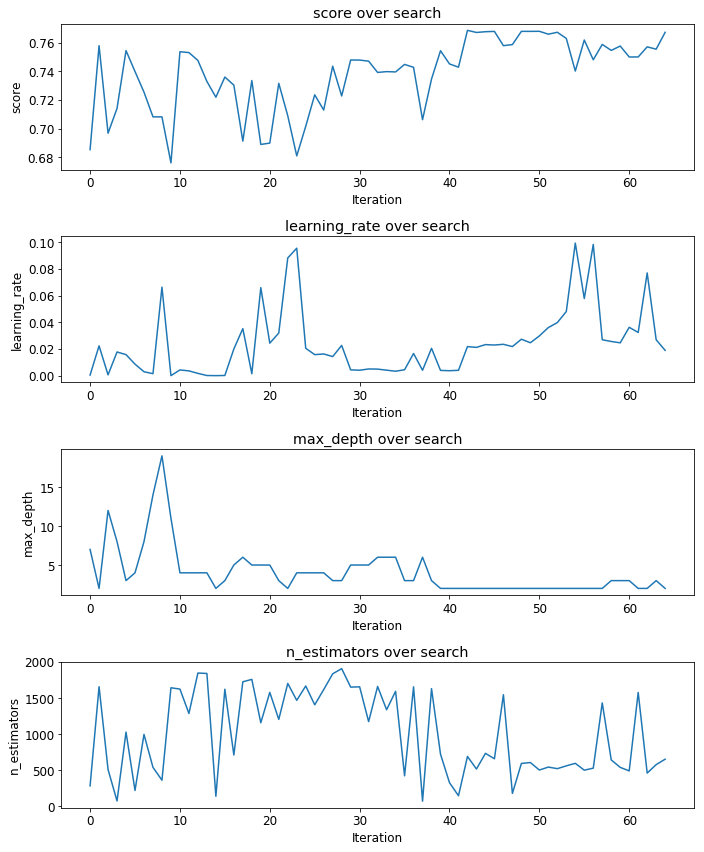

##################### [Scikit-Optimize dummy minimize] #####################         
         
   evaluated in:          123.53 s        
   best cros val auc was: 0.75344        
   best test auc was:     0.72618        
   best params:           {'learning_rate': 0.01129013355909267, 'max_depth': 3, 'n_estimators': 1440} 



-----------Ploting graphs for searched parameters for Scikit-Optimize dummy minimize-----------



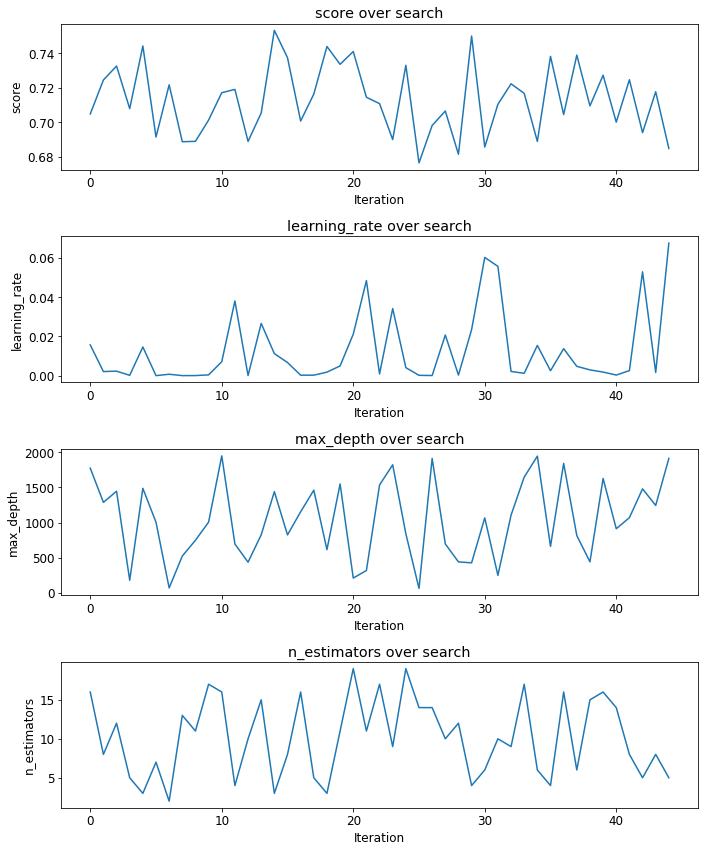

##################### [Scikit-Optimize forest minimize] #####################         
         
   evaluated in:          103.44 s        
   best cros val auc was: 0.76790        
   best test auc was:     0.73092        
   best params:           {'learning_rate': 0.009437288237777465, 'max_depth': 2, 'n_estimators': 1492} 



-----------Ploting graphs for searched parameters for Scikit-Optimize forest minimize-----------



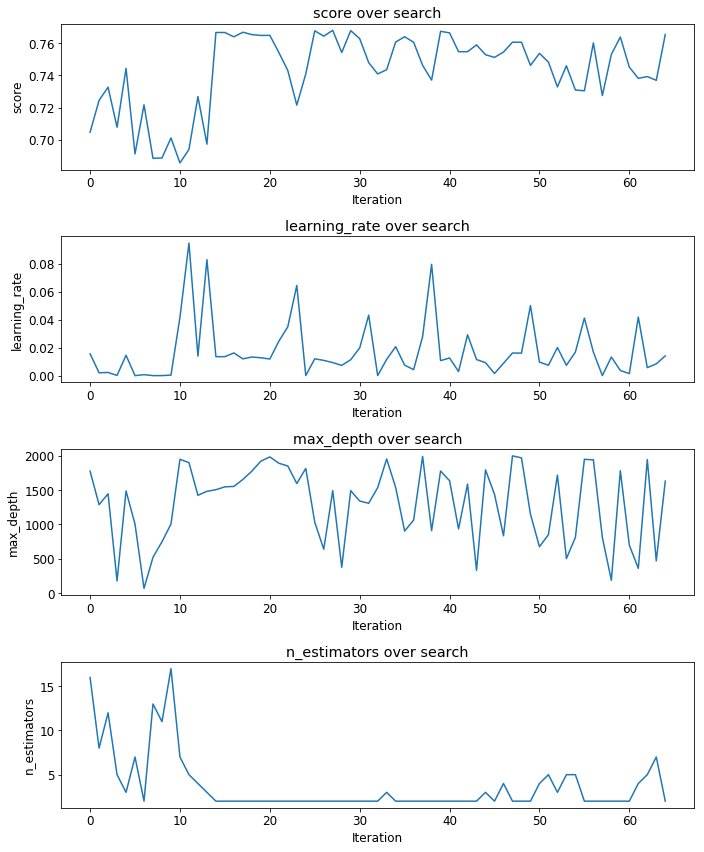

##################### [Scikit-Optimize gbrt minimize] #####################         
         
   evaluated in:          119.07 s        
   best cros val auc was: 0.76799        
   best test auc was:     0.73104        
   best params:           {'learning_rate': 0.009593040587943026, 'max_depth': 2, 'n_estimators': 1735} 



-----------Ploting graphs for searched parameters for Scikit-Optimize gbrt minimize-----------



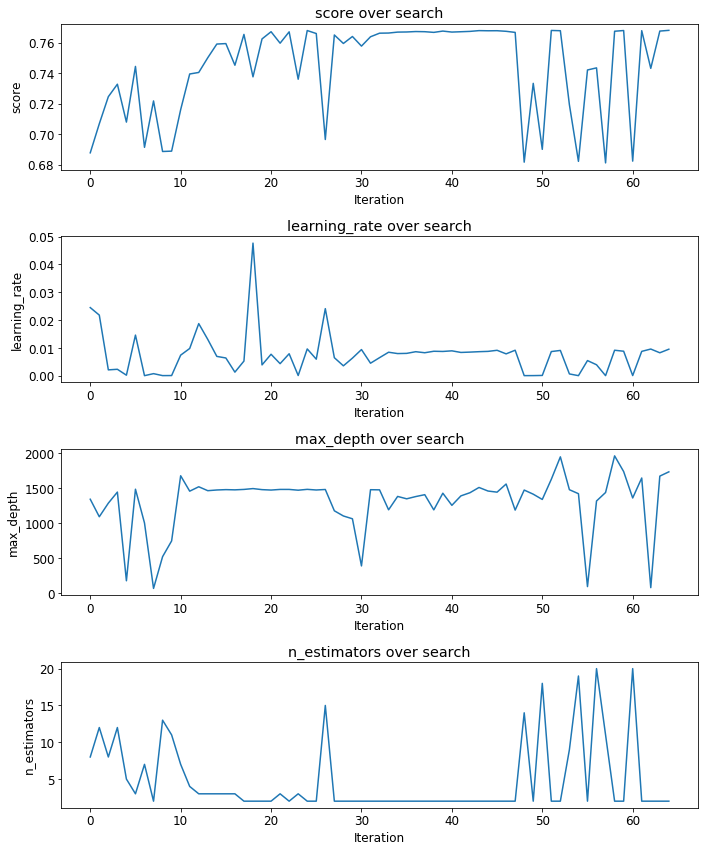

In [67]:
plot_params_of_algo(4)
plot_params_of_algo(5)
plot_params_of_algo(6)
plot_params_of_algo(7)

All Scikit-Optimize algortihms perforemd very well exccept of dummy minimize which seems to be searching random parameter combinations.

##################### [GPyOpt] #####################         
         
   evaluated in:          126.40 s        
   best cros val auc was: 0.75965        
   best test auc was:     0.73279        
   best params:           {'learning_rate': 0.004189222484616866, 'max_depth': 3, 'n_estimators': 1920} 



-----------Ploting graphs for searched parameters for GPyOpt-----------



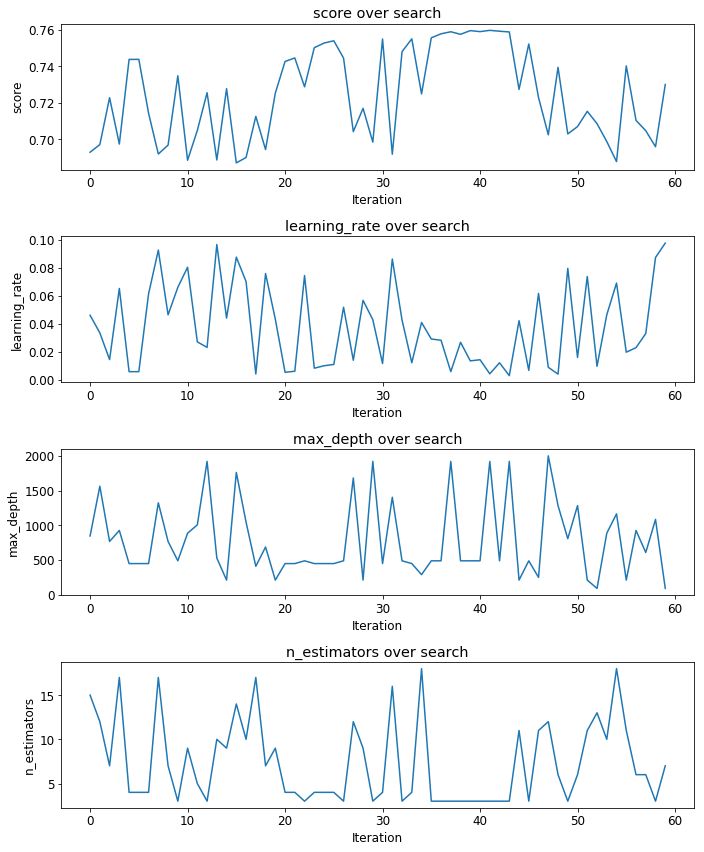

In [68]:
plot_params_of_algo(8)

GpyOpt even though seems to jump around all parameter combinations had best test score.

##################### [Evolutionary Algorithm Search] #####################         
         
   evaluated in:          146.78 s        
   best cros val auc was: 0.76830        
   best test auc was:     0.73100        
   best params:           {'learning_rate': 0.029205555121827452, 'max_depth': 2, 'n_estimators': 479, 'random_state': 42} 



-----------Ploting graphs for searched parameters for Evolutionary Algorithm Search-----------



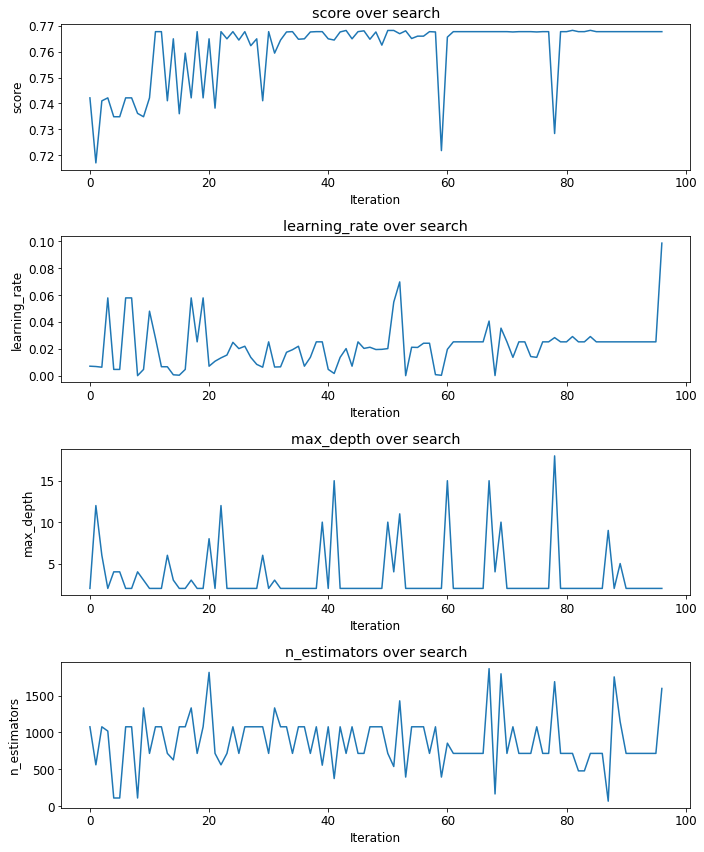

In [69]:
plot_params_of_algo(9)

Evolutionary algorithm performes many test in one combination and thanks to that it could focus in the areas of best scores.

##################### [BTB] #####################         
         
   evaluated in:          38.92 s        
   best cros val auc was: 0.76841        
   best test auc was:     0.72980        
   best params:           {'n_estimators': 393, 'max_depth': 2, 'learning_rate': 0.040647759135880125} 



-----------Ploting graphs for searched parameters for BTB-----------



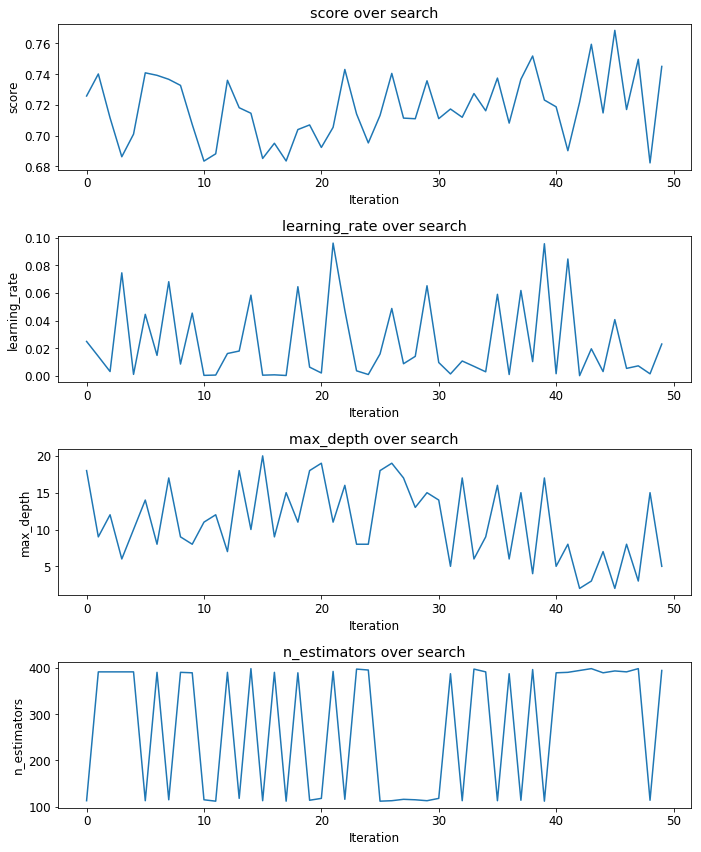

In [70]:
plot_params_of_algo(10)

BTB seems to be consisten and increases score over each iteration.

Lets now see how the distribution of searched parameters changed with each algorithm.

##################### [GridSearch] #####################         
         
   evaluated in:          104.89 s        
   best cros val auc was: 0.76316        
   best test auc was:     0.72839        
   best params:           {'learning_rate': 0.0031622776601683794, 'max_depth': 2, 'n_estimators': 2000, 'random_state': 42} 



-----------Ploting graphs of density of searched parameters for GridSearch-----------



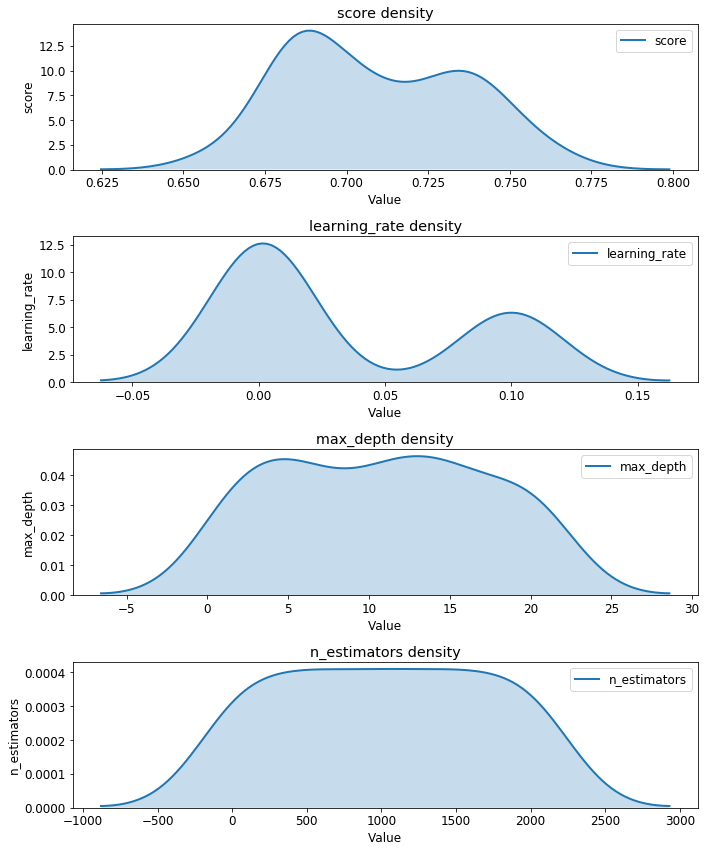

##################### [RandomSearch] #####################         
         
   evaluated in:          102.35 s        
   best cros val auc was: 0.76137        
   best test auc was:     0.72481        
   best params:           {'learning_rate': 0.04328761281083057, 'max_depth': 2, 'n_estimators': 697, 'random_state': 42} 



-----------Ploting graphs of density of searched parameters for RandomSearch-----------



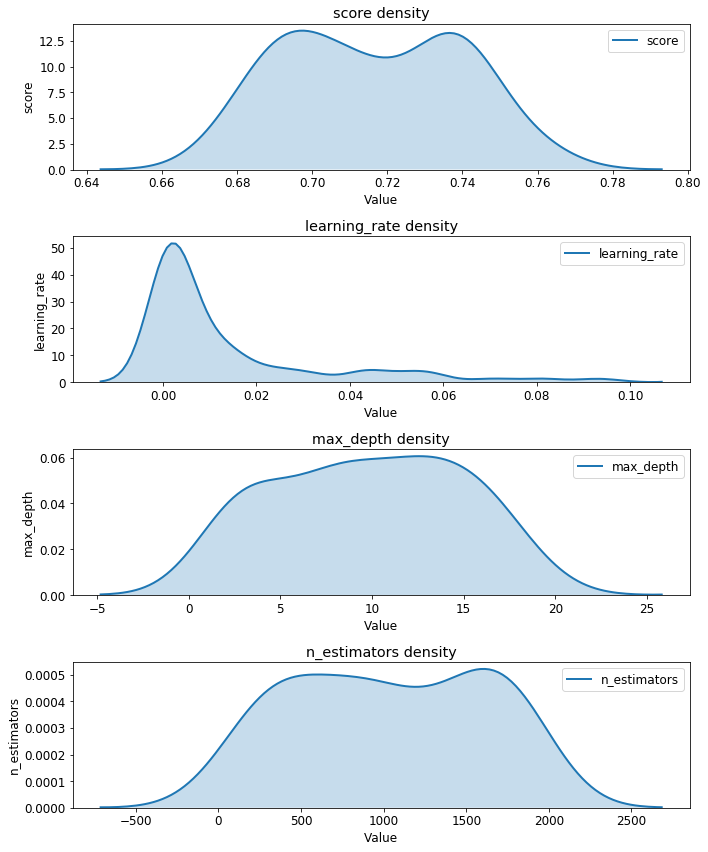

##################### [Hyperopt TPE] #####################         
         
   evaluated in:          93.12 s        
   best cros val auc was: 0.76064        
   best test auc was:     0.72657        
   best params:           {'learning_rate': 0.021503410723880467, 'max_depth': 2.0, 'n_estimators': 1501.0} 



-----------Ploting graphs of density of searched parameters for Hyperopt TPE-----------



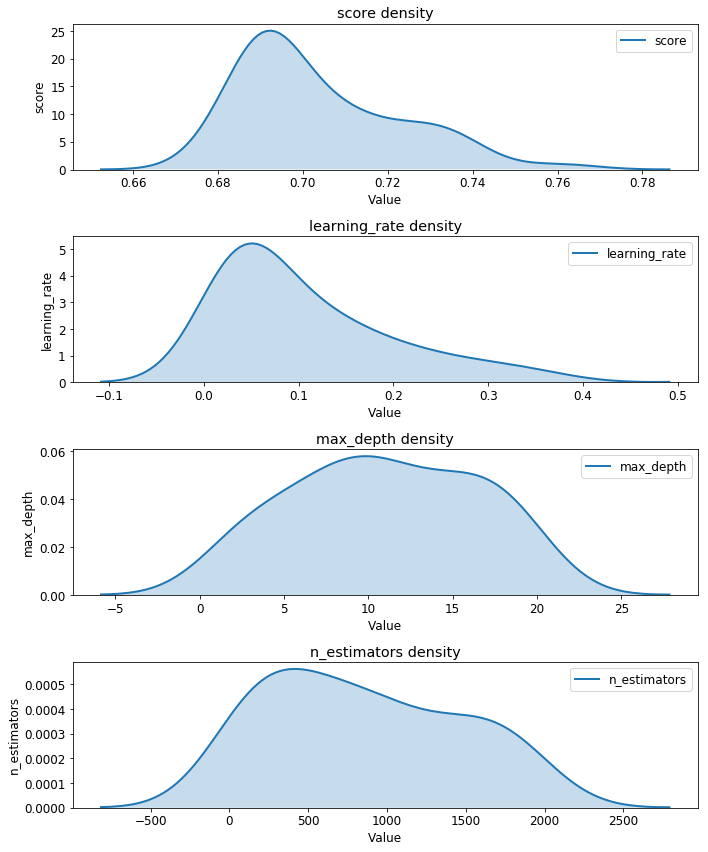

##################### [Hyperopt Anneal] #####################         
         
   evaluated in:          107.61 s        
   best cros val auc was: 0.74110        
   best test auc was:     0.72468        
   best params:           {'learning_rate': 0.02796190805453965, 'max_depth': 16.0, 'n_estimators': 229.0} 



-----------Ploting graphs of density of searched parameters for Hyperopt Anneal-----------



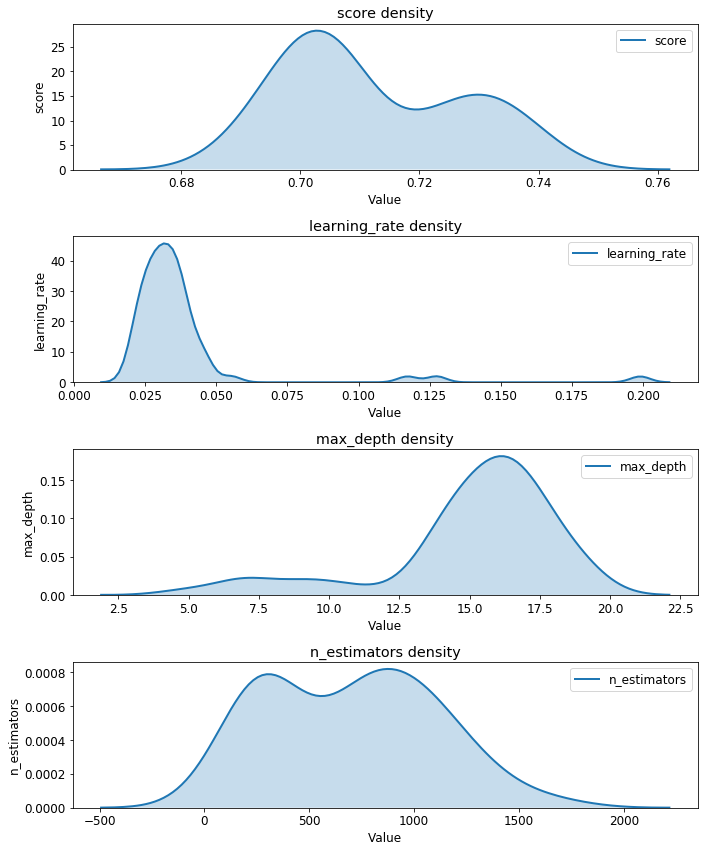

##################### [Scikit-Optimize API Bayes] #####################         
         
   evaluated in:          127.44 s        
   best cros val auc was: 0.76855        
   best test auc was:     0.73091        
   best params:           {'learning_rate': 0.021801357838009346, 'max_depth': 2, 'n_estimators': 691} 



-----------Ploting graphs of density of searched parameters for Scikit-Optimize API Bayes-----------



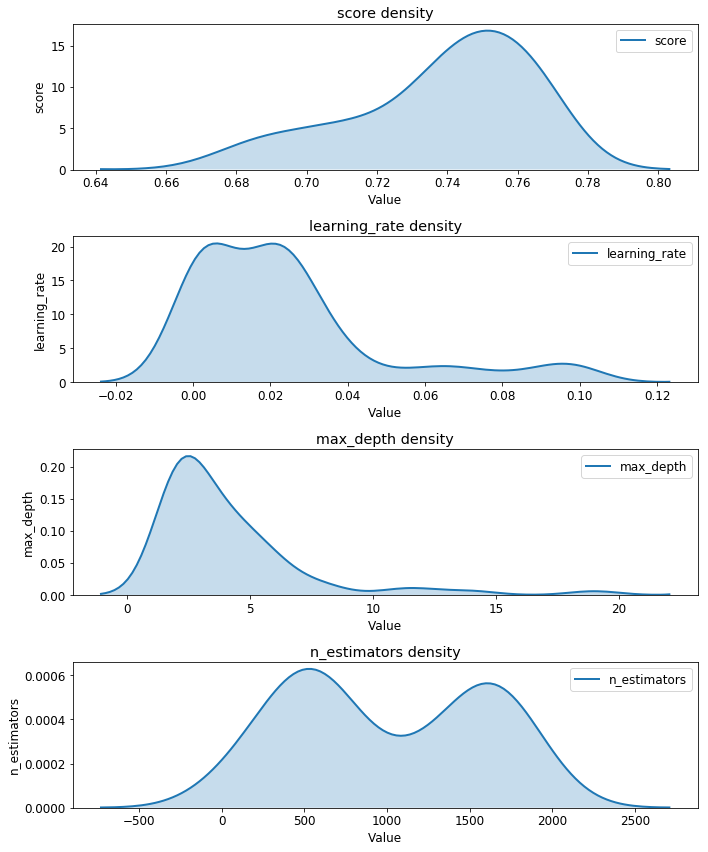

##################### [Scikit-Optimize dummy minimize] #####################         
         
   evaluated in:          123.53 s        
   best cros val auc was: 0.75344        
   best test auc was:     0.72618        
   best params:           {'learning_rate': 0.01129013355909267, 'max_depth': 3, 'n_estimators': 1440} 



-----------Ploting graphs of density of searched parameters for Scikit-Optimize dummy minimize-----------



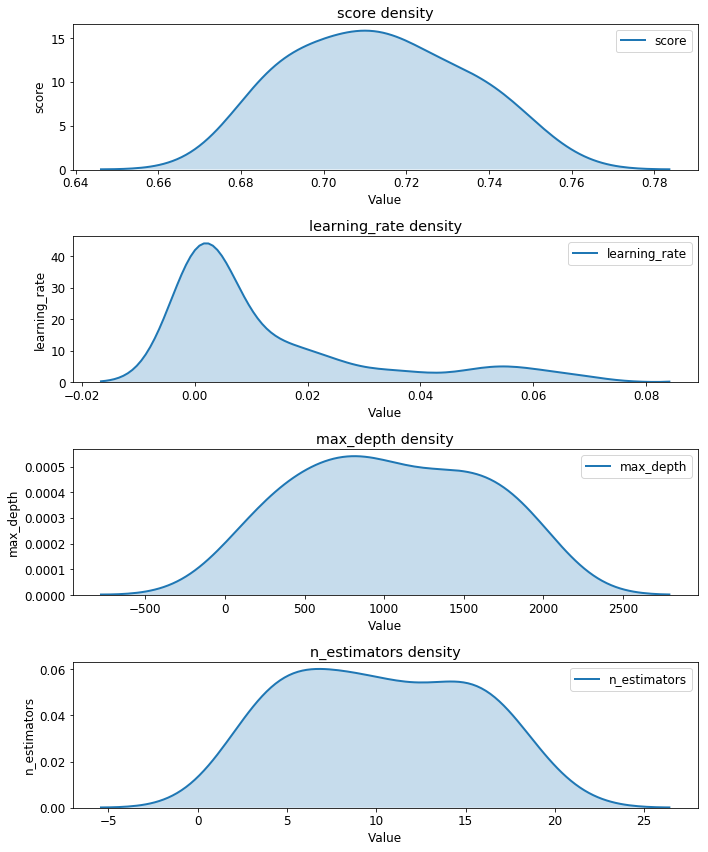

##################### [Scikit-Optimize forest minimize] #####################         
         
   evaluated in:          103.44 s        
   best cros val auc was: 0.76790        
   best test auc was:     0.73092        
   best params:           {'learning_rate': 0.009437288237777465, 'max_depth': 2, 'n_estimators': 1492} 



-----------Ploting graphs of density of searched parameters for Scikit-Optimize forest minimize-----------



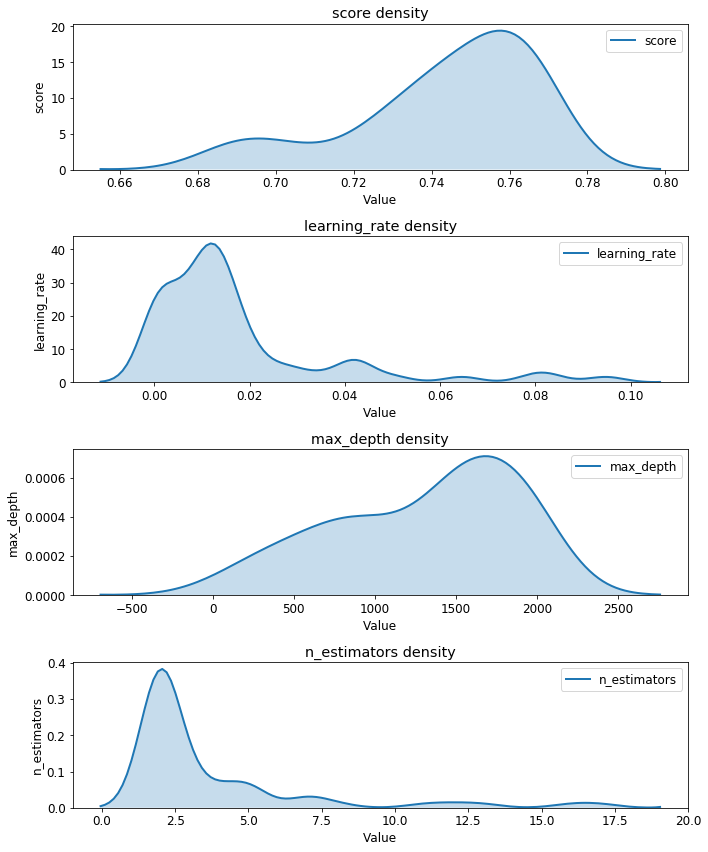

##################### [Scikit-Optimize gbrt minimize] #####################         
         
   evaluated in:          119.07 s        
   best cros val auc was: 0.76799        
   best test auc was:     0.73104        
   best params:           {'learning_rate': 0.009593040587943026, 'max_depth': 2, 'n_estimators': 1735} 



-----------Ploting graphs of density of searched parameters for Scikit-Optimize gbrt minimize-----------



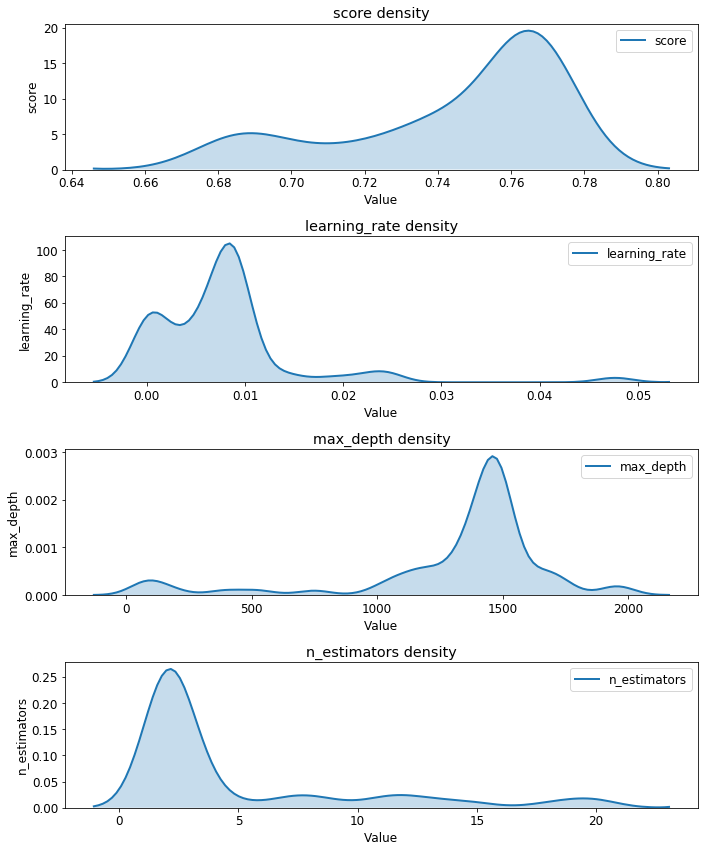

##################### [GPyOpt] #####################         
         
   evaluated in:          126.40 s        
   best cros val auc was: 0.75965        
   best test auc was:     0.73279        
   best params:           {'learning_rate': 0.004189222484616866, 'max_depth': 3, 'n_estimators': 1920} 



-----------Ploting graphs of density of searched parameters for GPyOpt-----------



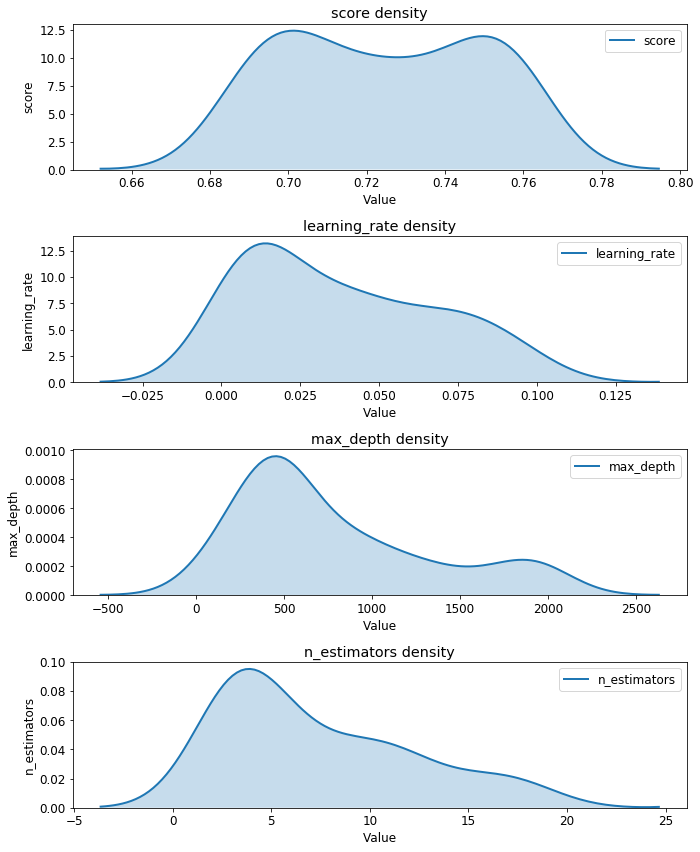

##################### [Evolutionary Algorithm Search] #####################         
         
   evaluated in:          146.78 s        
   best cros val auc was: 0.76830        
   best test auc was:     0.73100        
   best params:           {'learning_rate': 0.029205555121827452, 'max_depth': 2, 'n_estimators': 479, 'random_state': 42} 



-----------Ploting graphs of density of searched parameters for Evolutionary Algorithm Search-----------



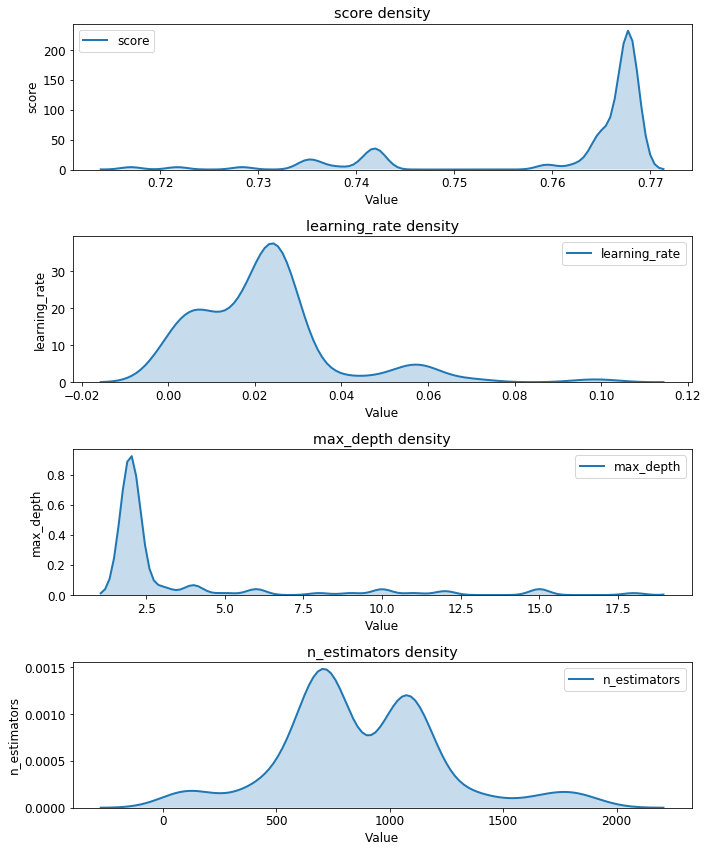

##################### [BTB] #####################         
         
   evaluated in:          38.92 s        
   best cros val auc was: 0.76841        
   best test auc was:     0.72980        
   best params:           {'n_estimators': 393, 'max_depth': 2, 'learning_rate': 0.040647759135880125} 



-----------Ploting graphs of density of searched parameters for BTB-----------



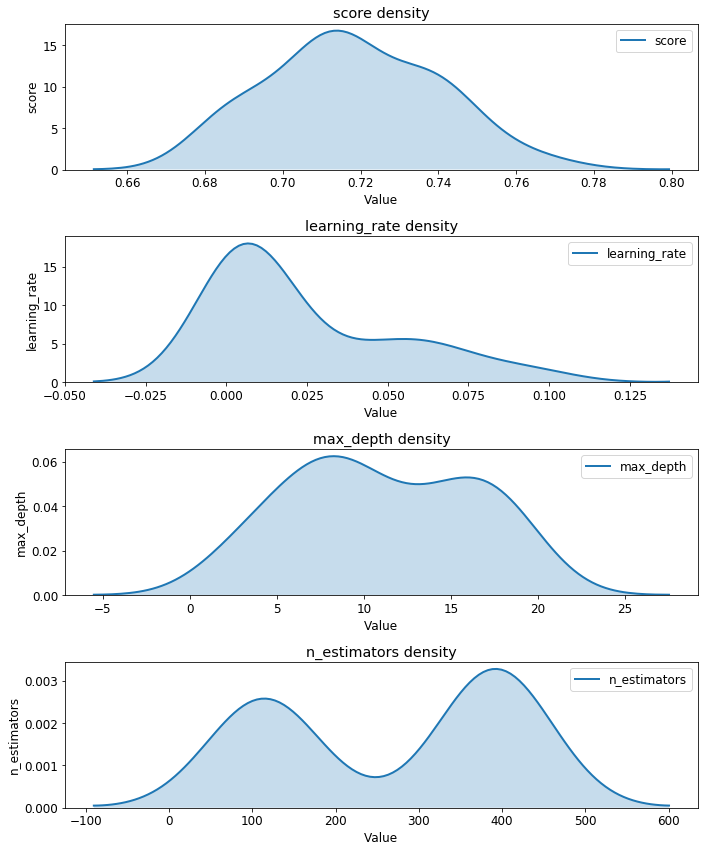

In [73]:
for algo in evaluated_array:
    print(algo)
    algo.plot_dist()

GridSearch and RandomSearch distributions of parameters don't differ that much. Only learning rate is significantly diffrent since RandomSearch randomly picks values for learning rate from logarythmic scaled values. In both cases score distribution is mostly even. 

##################### [GridSearch] #####################         
         
   evaluated in:          104.89 s        
   best cros val auc was: 0.76316        
   best test auc was:     0.72839        
   best params:           {'learning_rate': 0.0031622776601683794, 'max_depth': 2, 'n_estimators': 2000, 'random_state': 42} 



-----------Ploting graphs with linreg for GridSearch-----------



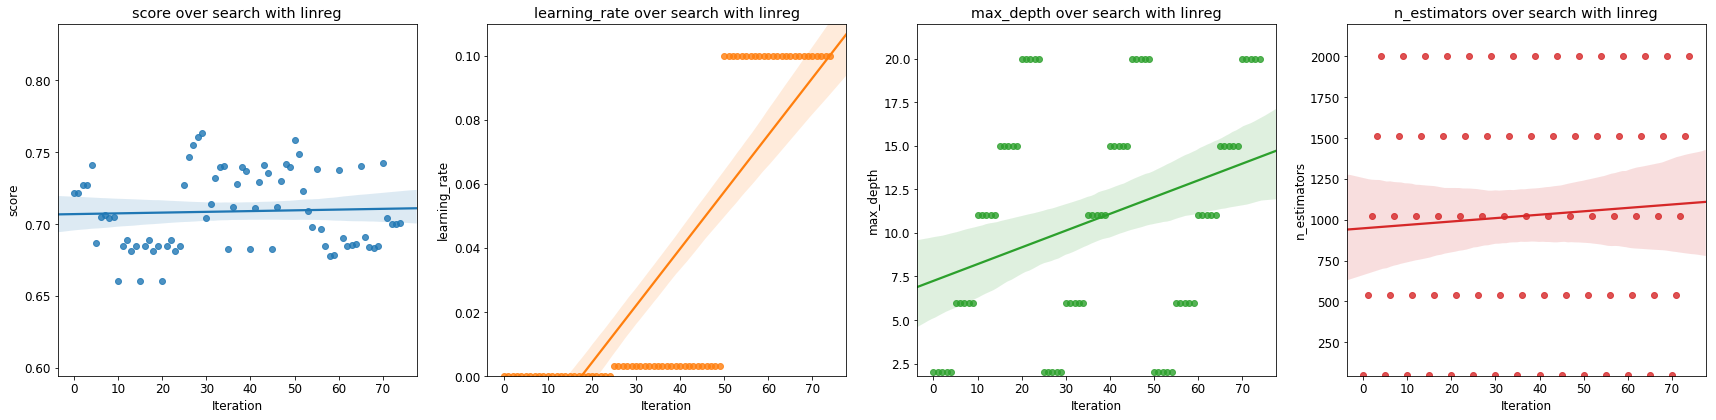

##################### [RandomSearch] #####################         
         
   evaluated in:          102.35 s        
   best cros val auc was: 0.76137        
   best test auc was:     0.72481        
   best params:           {'learning_rate': 0.04328761281083057, 'max_depth': 2, 'n_estimators': 697, 'random_state': 42} 



-----------Ploting graphs with linreg for RandomSearch-----------



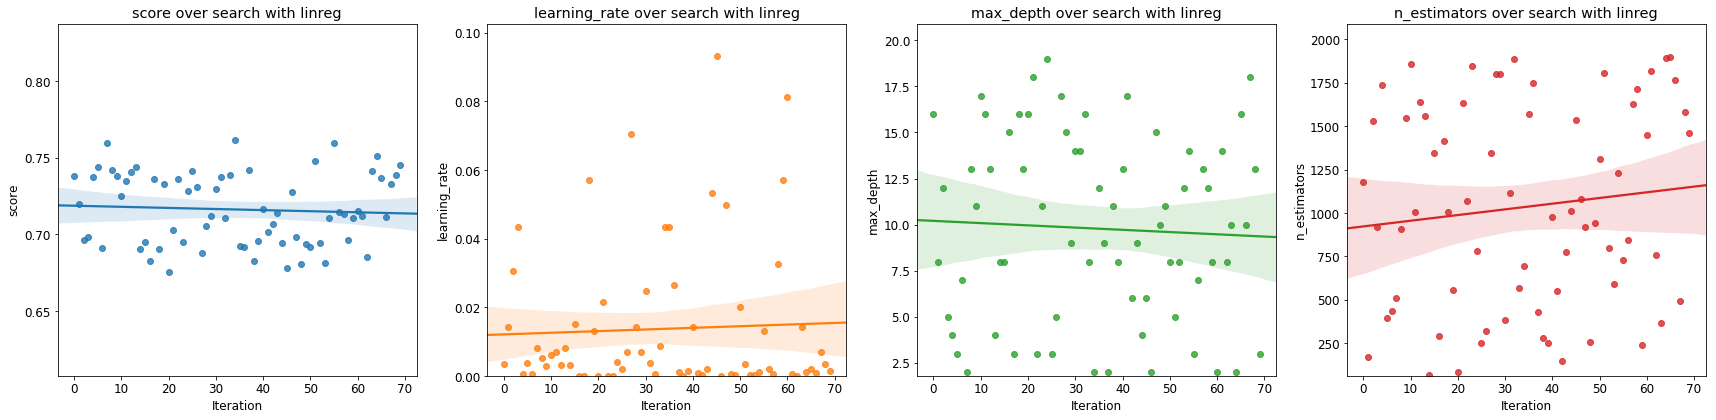

##################### [Hyperopt TPE] #####################         
         
   evaluated in:          93.12 s        
   best cros val auc was: 0.76064        
   best test auc was:     0.72657        
   best params:           {'learning_rate': 0.021503410723880467, 'max_depth': 2.0, 'n_estimators': 1501.0} 



-----------Ploting graphs with linreg for Hyperopt TPE-----------



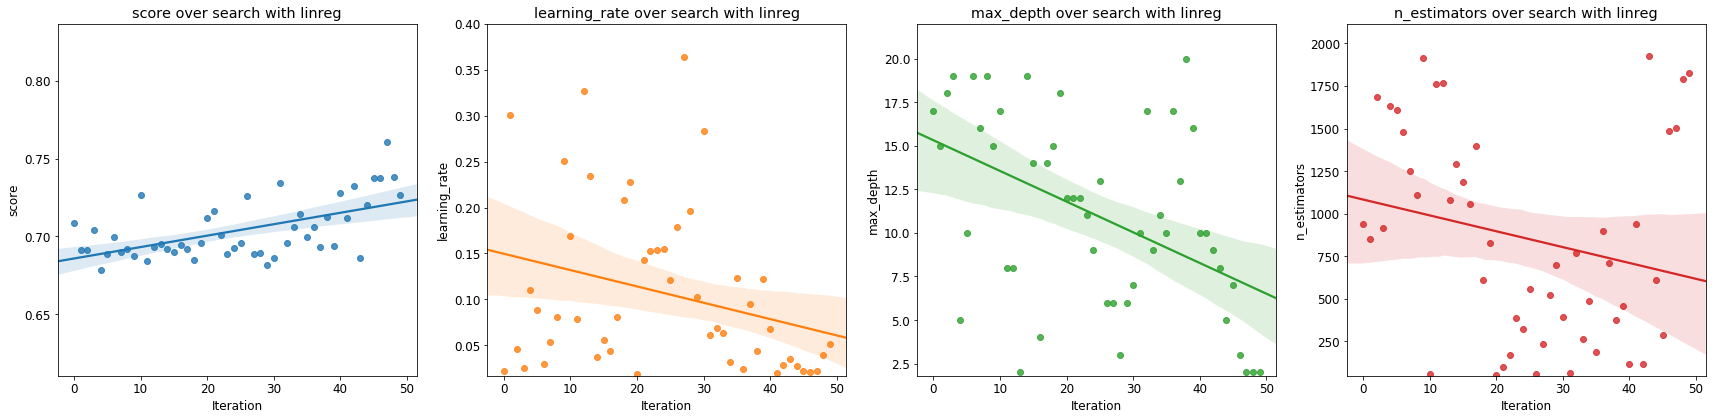

##################### [Hyperopt Anneal] #####################         
         
   evaluated in:          107.61 s        
   best cros val auc was: 0.74110        
   best test auc was:     0.72468        
   best params:           {'learning_rate': 0.02796190805453965, 'max_depth': 16.0, 'n_estimators': 229.0} 



-----------Ploting graphs with linreg for Hyperopt Anneal-----------



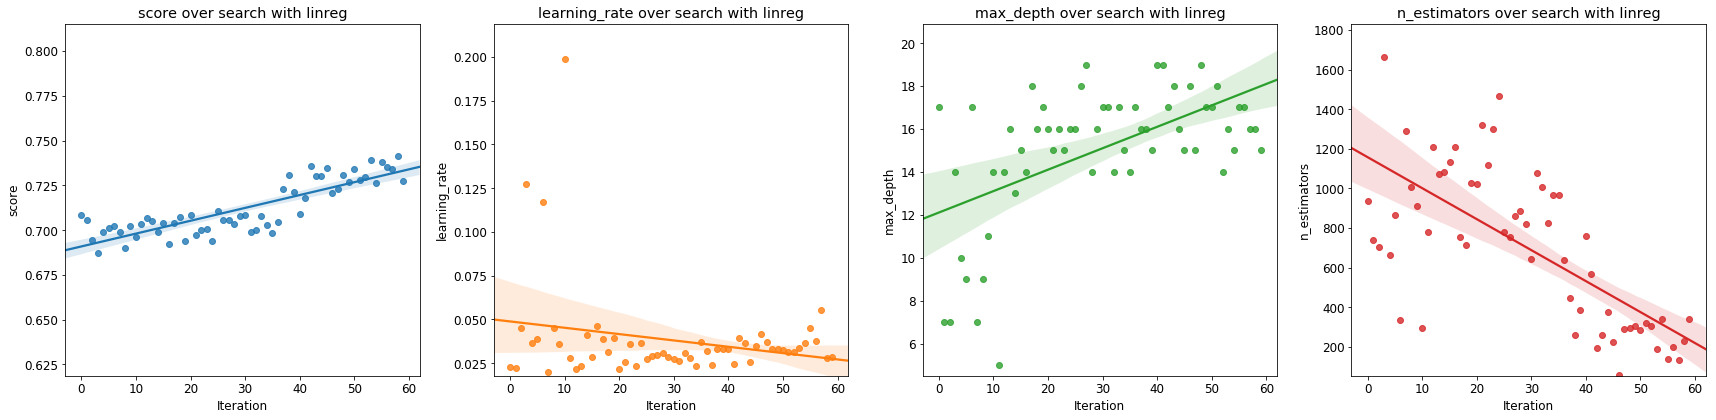

##################### [Scikit-Optimize API Bayes] #####################         
         
   evaluated in:          127.44 s        
   best cros val auc was: 0.76855        
   best test auc was:     0.73091        
   best params:           {'learning_rate': 0.021801357838009346, 'max_depth': 2, 'n_estimators': 691} 



-----------Ploting graphs with linreg for Scikit-Optimize API Bayes-----------



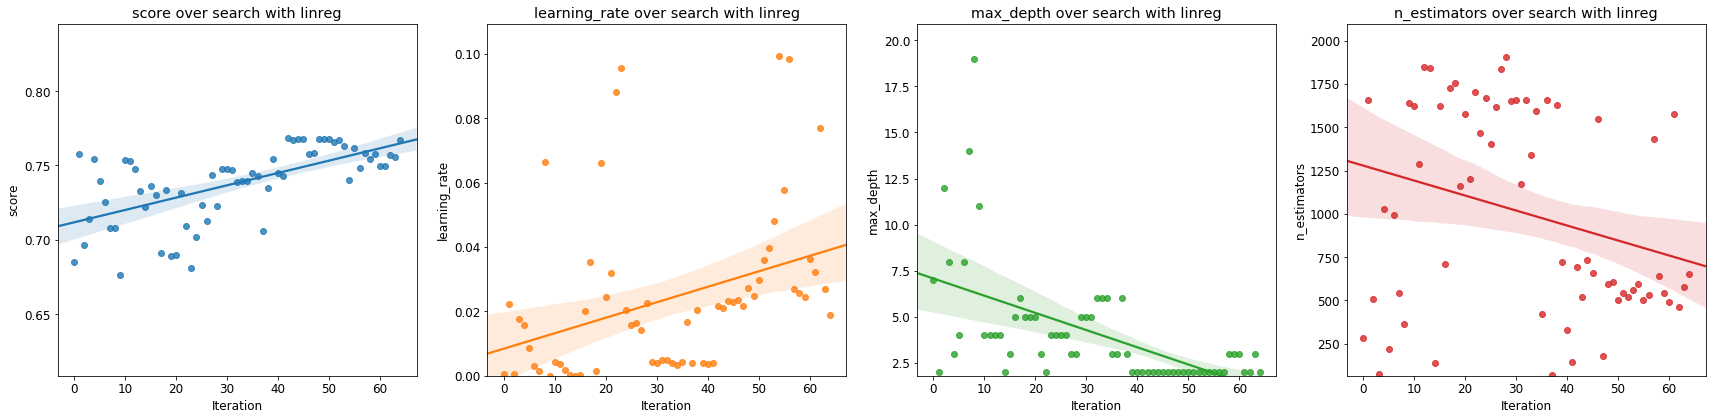

##################### [Scikit-Optimize dummy minimize] #####################         
         
   evaluated in:          123.53 s        
   best cros val auc was: 0.75344        
   best test auc was:     0.72618        
   best params:           {'learning_rate': 0.01129013355909267, 'max_depth': 3, 'n_estimators': 1440} 



-----------Ploting graphs with linreg for Scikit-Optimize dummy minimize-----------



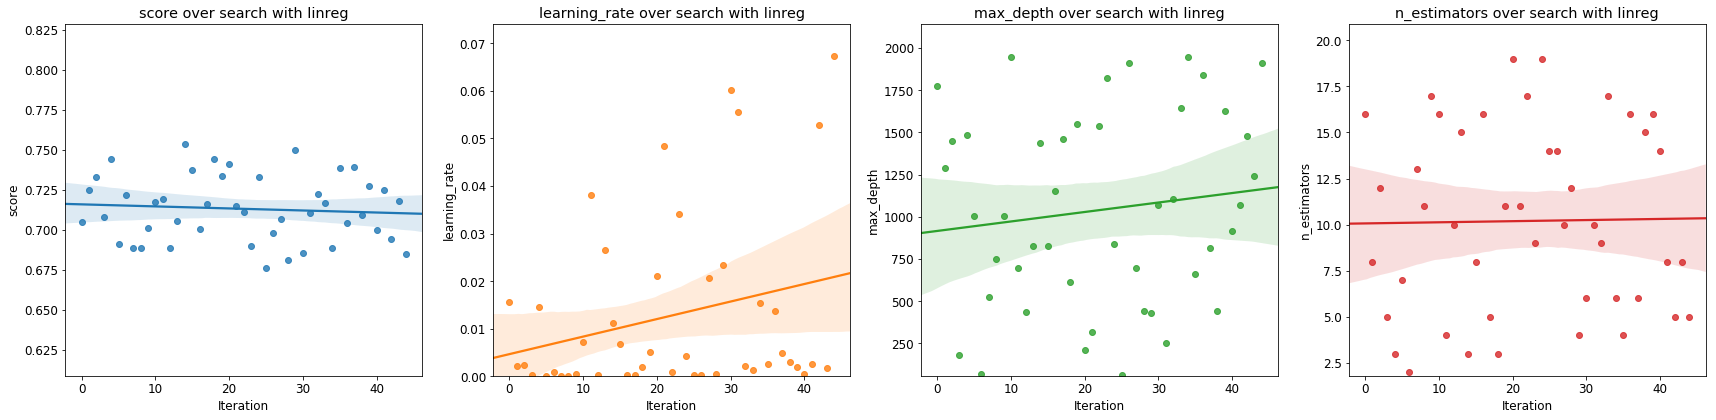

##################### [Scikit-Optimize forest minimize] #####################         
         
   evaluated in:          103.44 s        
   best cros val auc was: 0.76790        
   best test auc was:     0.73092        
   best params:           {'learning_rate': 0.009437288237777465, 'max_depth': 2, 'n_estimators': 1492} 



-----------Ploting graphs with linreg for Scikit-Optimize forest minimize-----------



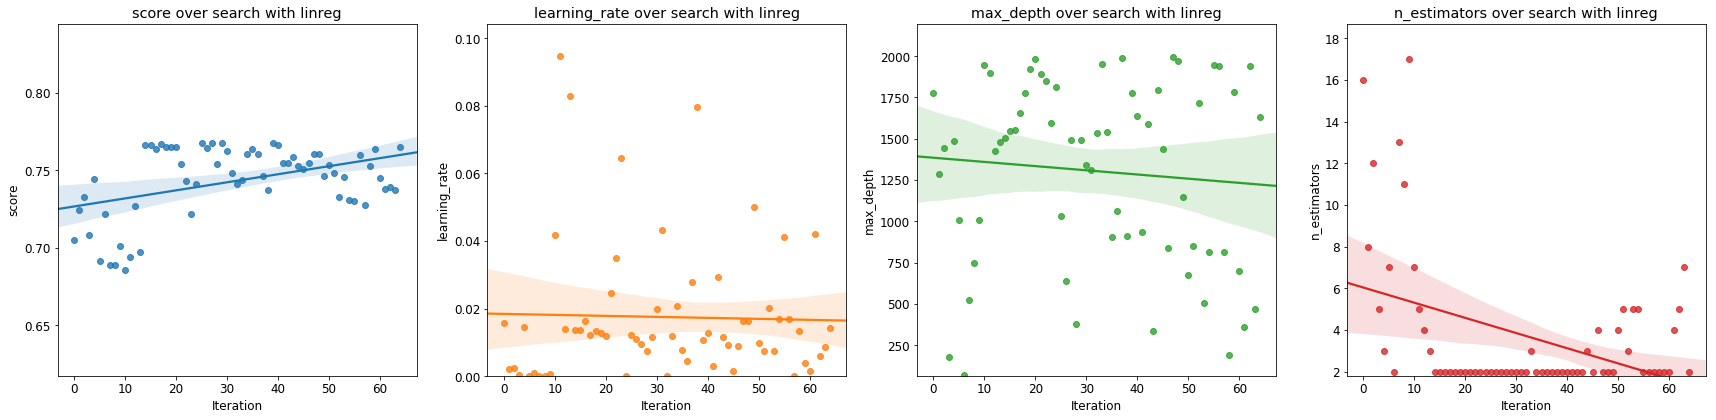

##################### [Scikit-Optimize gbrt minimize] #####################         
         
   evaluated in:          119.07 s        
   best cros val auc was: 0.76799        
   best test auc was:     0.73104        
   best params:           {'learning_rate': 0.009593040587943026, 'max_depth': 2, 'n_estimators': 1735} 



-----------Ploting graphs with linreg for Scikit-Optimize gbrt minimize-----------



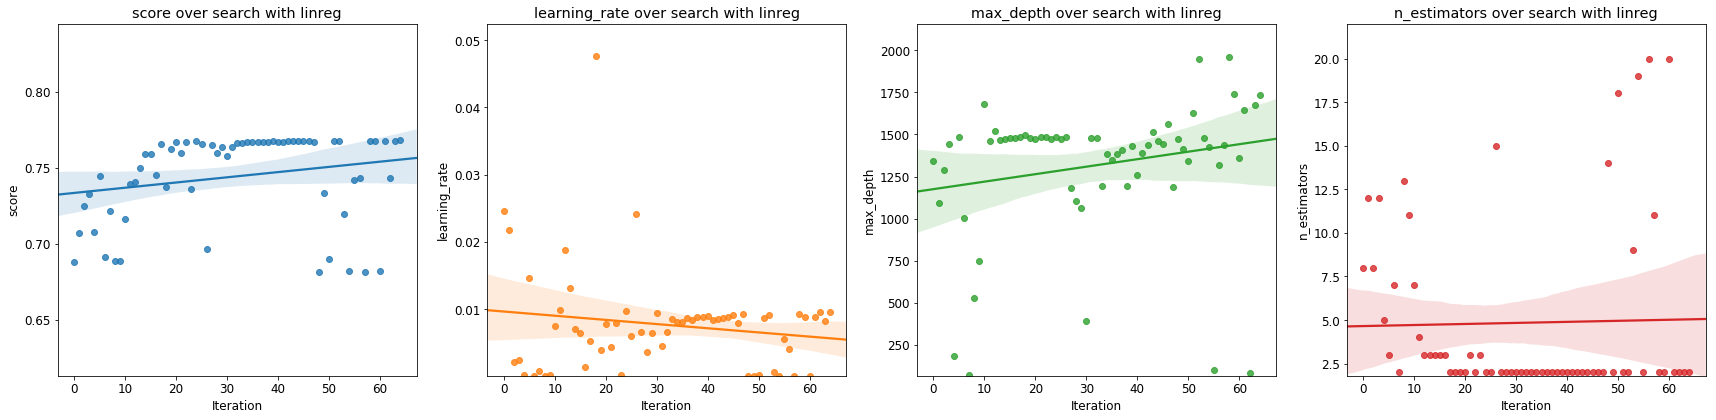

##################### [GPyOpt] #####################         
         
   evaluated in:          126.40 s        
   best cros val auc was: 0.75965        
   best test auc was:     0.73279        
   best params:           {'learning_rate': 0.004189222484616866, 'max_depth': 3, 'n_estimators': 1920} 



-----------Ploting graphs with linreg for GPyOpt-----------



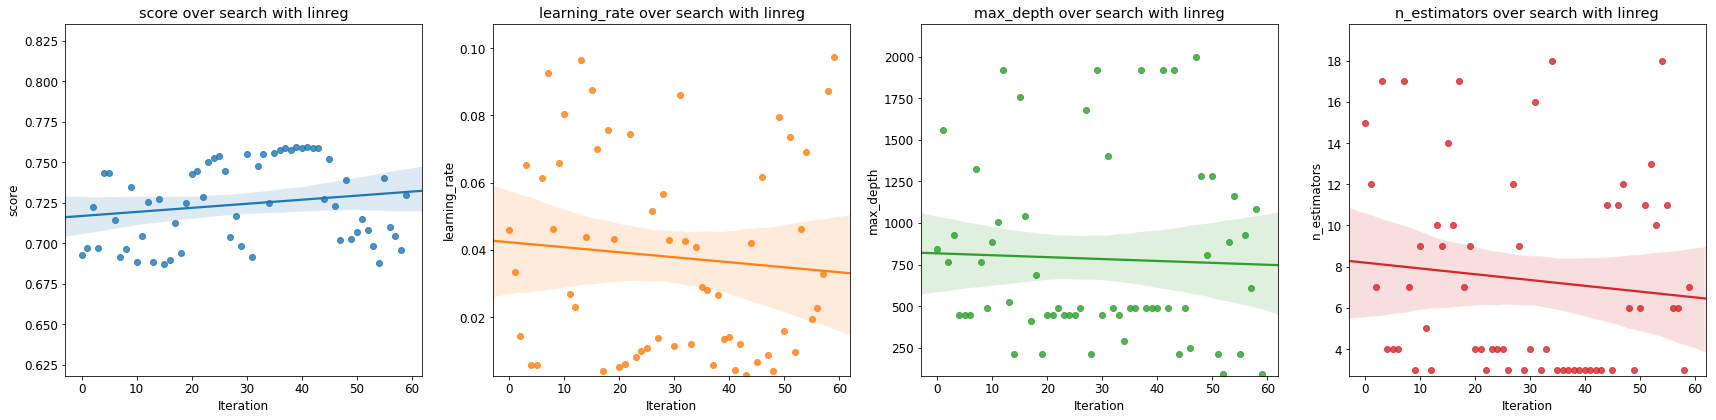

##################### [Evolutionary Algorithm Search] #####################         
         
   evaluated in:          146.78 s        
   best cros val auc was: 0.76830        
   best test auc was:     0.73100        
   best params:           {'learning_rate': 0.029205555121827452, 'max_depth': 2, 'n_estimators': 479, 'random_state': 42} 



-----------Ploting graphs with linreg for Evolutionary Algorithm Search-----------



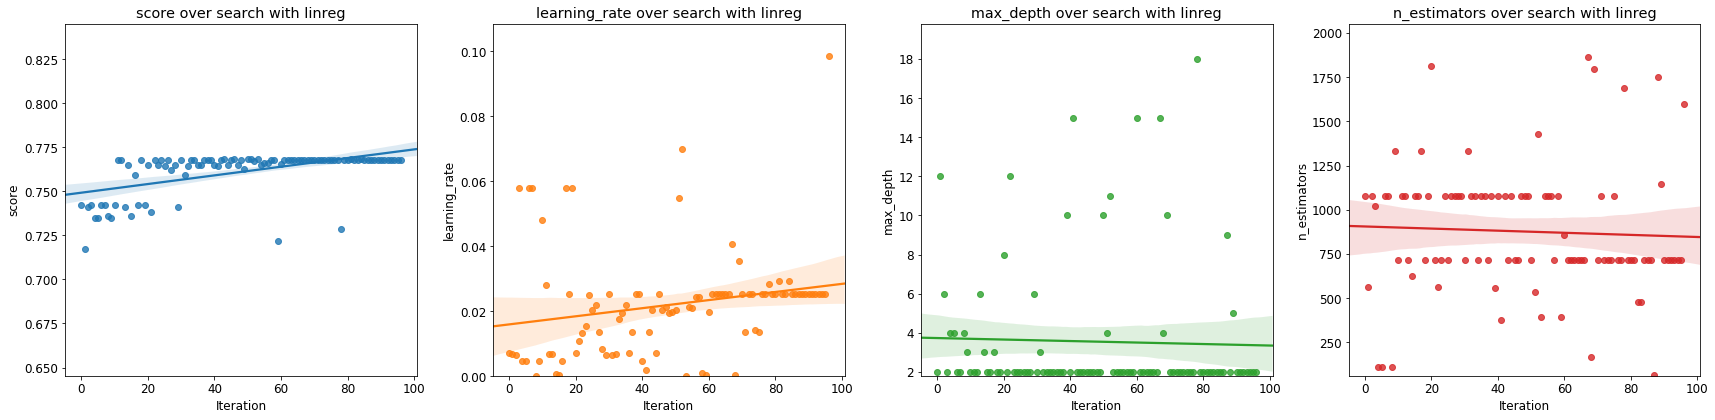

##################### [BTB] #####################         
         
   evaluated in:          38.92 s        
   best cros val auc was: 0.76841        
   best test auc was:     0.72980        
   best params:           {'n_estimators': 393, 'max_depth': 2, 'learning_rate': 0.040647759135880125} 



-----------Ploting graphs with linreg for BTB-----------



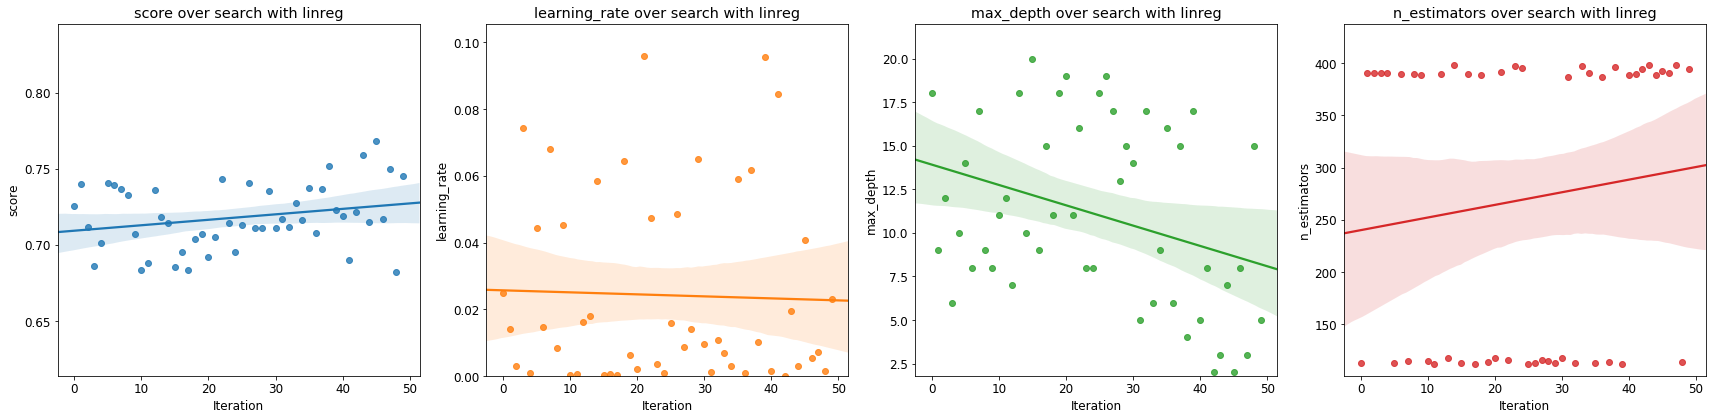

In [75]:
for algo in evaluated_array:
    print(algo)
    algo.plot_with_linreg()

In [266]:
######### tpot

In [71]:
tpot_config = {
    'lightgbm.sklearn.LGBMClassifier': {
        'learning_rate': np.logspace(-4, -1, 300),
        'max_depth':  np.linspace(2,20,18,dtype = int),
        'n_estimators': np.linspace(50,2000,1950, dtype = int),
        'random_state': [random_state]
    }
}

In [72]:
%%time
tpot = TPOTClassifier(
    generations=7, 
    population_size=8, 
    verbosity=2,
    scoring='roc_auc',
    cv=kf,
    n_jobs=-1,
    random_state=random_state,
    #periodic_checkpoint_folder='tpot_results',
    config_dict=tpot_config
)
tpot.fit(X_train, y_train)

A Jupyter Widget

Generation 1 - Current best internal CV score: 0.7420268115459729
Generation 2 - Current best internal CV score: 0.7474665360102446
Generation 3 - Current best internal CV score: 0.7474665360102446
Generation 4 - Current best internal CV score: 0.7491798947430438
Generation 5 - Current best internal CV score: 0.7491798947430438
Generation 6 - Current best internal CV score: 0.7578617441105517
Generation 7 - Current best internal CV score: 0.7622888546486963

Best pipeline: LGBMClassifier(CombineDFs(input_matrix, LGBMClassifier(input_matrix, learning_rate=0.013093533273536108, max_depth=2, n_estimators=417, random_state=42)), learning_rate=0.002015337685941733, max_depth=3, n_estimators=1265, random_state=42)
Wall time: 2min 23s


In [78]:
tpot.score(X_test, y_test)

0.7184656159114364

In [74]:
roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])

0.7184656159114364

In [75]:
tpot.fitted_pipeline_.steps

[('featureunion', FeatureUnion(n_jobs=None,
         transformer_list=[('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True,
            func=<function copy at 0x0000013AFA045F28>, inv_kw_args=None,
            inverse_func=None, kw_args=None, pass_y='deprecated',
            validate=None)), ('stackingestimator', StackingEsti..., reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=1)))],
         transformer_weights=None)),
 ('lgbmclassifier',
  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          learning_rate=0.002015337685941733, max_depth=3,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=1265, n_jobs=-1, num_leaves=31, objective=None,
          random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=1))]

In [76]:
tpot.export('tpot_pipeline.py')

True

In [13]:
# ########### auto_ml##########
# from auto_ml.utils import get_boston_dataset

# df_train, df_test = get_boston_dataset()

In [85]:
data = pd.read_csv('data/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']


# train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
# y_test = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))


df_train = train.drop(columns = ['ORIGIN'])
df_test = test.drop(columns = ['ORIGIN'])

# X_train = np.array(train)
# X_test = np.array(test)
# y_train = train_labels[:]

In [86]:
# seed(random_state)
# # Load data
# df_train = pd.DataFrame(train_data)
# df_train.columns = diabetes.feature_names
# df_train['targets'] = train_targets
# df_test = pd.DataFrame(test_data)
# df_test.columns = diabetes.feature_names
# df_test['targets'] = test_targets

df_train, fl_data = train_test_split(df_train, test_size=0.33)

In [87]:
seed(random_state)


column_descriptions = {
    'CARAVAN': 'output'
}

ml_predictor = Predictor(
    type_of_estimator='classifier', 
    column_descriptions=column_descriptions
)

ml_predictor.train(
    df_train, 
    model_names = 'LGBMClassifier',
    cv = kf,
    feature_learning = True,
#     fl_data = df_train.copy(),
    fl_data = fl_data,
    training_params={'batch_size': 300, 'verbose': 2}
)

# Score the model on test data
test_score = ml_predictor.score(df_test, df_test.CARAVAN)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{'batch_size': 300, 'verbose': 2}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'epochs': 1000, 'batch_size': 300, 'verbose': 2}
Running basic data cleaning
Performing feature scaling
Fitting DataFrameVectorizer


********************************************************************************************
About to fit the pipeline for the model DeepLearningClassifier to predict CARAVAN
Started at:
2019-02-19 21:33:43

We will stop training early if we have not seen an improvement in validation accuracy in 25 epochs
To measure validation accuracy, we will split off a random 10 percent of yo

Epoch 58/1000
 - 1s - loss: 0.2076 - acc: 0.9449 - poisson: 0.1940 - val_loss: 0.2046 - val_acc: 0.9516 - val_poisson: 0.1896
Epoch 59/1000
 - 1s - loss: 0.2072 - acc: 0.9449 - poisson: 0.1939 - val_loss: 0.2041 - val_acc: 0.9516 - val_poisson: 0.1888
Epoch 60/1000
 - 1s - loss: 0.2072 - acc: 0.9449 - poisson: 0.1938 - val_loss: 0.2040 - val_acc: 0.9516 - val_poisson: 0.1885
Epoch 61/1000
 - 1s - loss: 0.2068 - acc: 0.9449 - poisson: 0.1933 - val_loss: 0.2053 - val_acc: 0.9516 - val_poisson: 0.1895
Epoch 00061: early stopping
Finished training the pipeline!
Total training time:
0:00:50
Now using the model training_params that you passed in:
{'batch_size': 300, 'verbose': 2}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'n_estimators': 2000, 'learning_rate': 0.15, 'num_leaves': 8, 'lambda_l2': 0.001, 'histogram_pool_size': 16384, 'batch_size': 300, 'verbose': 2}


***************************************************

+----+---------------------+--------------+---------+-------------------+-------------------+-----------+-----------+-----------+-----------+


*******
Legend:
Importance = Feature Importance
     Explanation: A weighted measure of how much of the variance the model is able to explain is due to this column
FR_delta = Feature Response Delta Amount
     Explanation: Amount this column was incremented or decremented by to calculate the feature reponses
FR_Decrementing = Feature Response From Decrementing Values In This Column By One FR_delta
     Explanation: Represents how much the predicted output values respond to subtracting one FR_delta amount from every value in this column
FR_Incrementing = Feature Response From Incrementing Values In This Column By One FR_delta
     Explanation: Represents how much the predicted output values respond to adding one FR_delta amount to every value in this column
FRD_MAD = Feature Response From Decrementing- Median Absolute Delta
     Explanation: Tak

In [88]:
roc_auc_score(df_test.CARAVAN, ml_predictor.predict_proba(df_test)[:, 1])

0.714936851933756